In [2]:
import numpy as np
from scipy.stats import ttest_ind
from scipy.stats import norm
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [3]:
import matplotlib.pyplot as plt

In [4]:
import matplotlib
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['font.sans-serif'] = "Calibri"
matplotlib.rcParams['font.size'] = 14

In [8]:
arr = np.arange(16).reshape(4, 4)
print(arr)
ratio = 0.5
rands = np.random.rand(arr.shape[0] * arr.shape[1])
condition = rands < ratio
mask = np.flatnonzero(condition)
f = arr.flatten()
f[mask] *= 0
print(f.reshape(arr.shape))

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
[[ 0  0  2  0]
 [ 0  0  0  7]
 [ 0  0  0  0]
 [ 0 13  0 15]]


In [9]:
arr = np.arange(16).reshape(2, 8)
print(arr, arr.shape)
noised = add_noise(np.copy(arr), 0.5)
print(noised, noised.shape)

[[ 0  1  2  3  4  5  6  7]
 [ 8  9 10 11 12 13 14 15]] (2, 8)
[[ 0  1  2  3  0  0  6  0]
 [ 0  0  0 11 12 13 14 15]] (2, 8)


In [5]:
def add_noise(arr, ratio):
    rands = np.random.random_sample(arr.shape)
    noised = np.copy(arr)
    noised[rands < ratio] *= 0
    return noised

In [9]:
from minerva2 import Minerva2

# Creating Preexisting Knowledge

In [173]:
#These are the parameters for number of features, number of traces, and repetitions
FPT = 20
N_PROTOTYPES = 500
rep_mean = 1
rep_sd = 2
rep_size = N_PROTOTYPES
N_studied = 100
learning_probability = .45
probe_noise_ratio = .4

In [174]:
model = Minerva2(FPT)

In [175]:
#Creating the preexisting knowledge traces
T_knowledge = np.random.randint(-1,2,(N_PROTOTYPES, FPT))

In [176]:
normed_reps = np.random.normal(loc=0,scale=rep_sd,size=N_PROTOTYPES)

In [177]:
for i in range(len(normed_reps)):
    normed_reps[i] = abs(round(normed_reps[i]) + rep_mean)

In [178]:
import matplotlib.pyplot as plt

(array([170., 128.,  67.,  36.,  15.,   7.,   1.,   0.]),
 array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]),
 <a list of 8 Patch objects>)

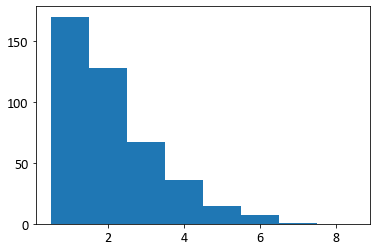

In [179]:
plt.hist(normed_reps, bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5])

In [180]:
# for each trace in KB
for t in range(T_knowledge.shape[0]):
    # add each trace based on rep weight
    for _ in range(repetition_weights[t]):
        #add to model
        if np.random.uniform() < learning_probability:
            model.add_trace(T_knowledge[t])

In [181]:
#Randomly select 1/2 of the T_Knowledge traces
T_studied_indices = np.random.choice(T_knowledge.shape[0],size=N_studied,replace=False)
T_studied = T_knowledge[T_studied_indices]
T_studied.shape, N_studied

((100, 20), 100)

In [182]:
#Assigning subset of T_knowledge traces to be either studied or unstudied
T_unstudied_indices = [i for i in range(len(T_knowledge)) if i not in T_studied_indices]
T_unstudied = T_knowledge[T_unstudied_indices]
T_unstudied.shape, N_PROTOTYPES, N_studied

((400, 20), 500, 100)

In [183]:
#add studied traces to model
model.add_traces(T_studied)

In [184]:
#Make probes for studied and unstudied stimuli
P_studied = np.copy(T_studied)
P_unstudied = np.copy(T_unstudied)

#Zero out half of probes
split_index = round(FPT * probe_noise_ratio)
P_studied[:, :split_index] *= 0
P_unstudied[:, :split_index] *= 0

In [185]:
#Get echo intensities
studied_intensities = model.get_echo_intensities(P_studied)
unstudied_intensities = model.get_echo_intensities(P_unstudied)

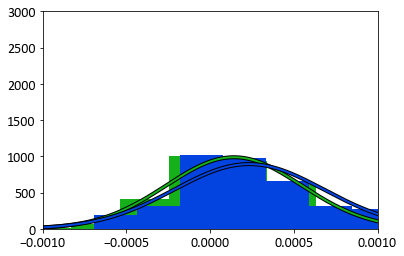

In [186]:
#Graph echo intensities
mu_studied, std_studied = norm.fit(studied_intensities)
mu_unstudied, std_unstudied = norm.fit(unstudied_intensities)

plt.hist(unstudied_intensities, color='xkcd:green', density=True)
plt.hist(studied_intensities, color='xkcd:blue', density=True)

xmin, xmax = plt.xlim(-.001, .001)
x = np.linspace(xmin, xmax, 10000)
plt.ylim(0, 3000)

P_unstudied = norm.pdf(x, mu_unstudied, std_unstudied)
plt.plot(x, P_unstudied, 'k',linewidth=4)
plt.plot(x, P_unstudied, 'xkcd:green',linewidth=2, label='UNSTUDIED: $\mu$ = {:.1e}, $\sigma$ = {:.1e}'.format(mu_unstudied, std_unstudied))

P_studied = norm.pdf(x, mu_studied, std_studied)
plt.plot(x, P_studied, 'k',linewidth=4)
plt.plot(x, P_studied, 'xkcd:blue',linewidth=2, label='STUDIED: $\mu$ = {:.1e}, $\sigma$ = {:.1e}'.format(mu_studied, std_studied))


# Semantic Knowledge Model

In [18]:
import math as math
def get_dprime(mean_a, mean_b, sd_a, sd_b):
    return (mean_a - mean_b) / math.sqrt(.5*(sd_a**2 + sd_b**2))

In [19]:
def get_accuracy(threshold, similarity, labels, needs_flipped=False):
    if needs_flipped: 
        thresholded = np.greater(similarity, threshold)
    else:
        thresholded = np.less(similarity, threshold)
    return np.sum(np.equal(thresholded, labels)) / labels.shape[0]

In [14]:
def PreKnowledge_Experiment(FPT, 
    N_PROTOTYPES,
    rep_mean,
    rep_sd,
    study_ratio,
    trace_noise_ratio_KB,
    trace_noise_ratio_study,
    probe_noise_ratio,
    N_study_repetitions=1,
    show_novel_intensities=False):
#These are the parameters for number of features, number of traces, and repetitions


    model = Minerva2(FPT)

    #Creating the preexisting knowledge traces
    T_knowledge = np.random.randint(-1,2,(N_PROTOTYPES, FPT))

    normed_reps = np.random.normal(loc=0,scale=rep_sd,size=N_PROTOTYPES)

    for i in range(len(normed_reps)):
        normed_reps[i] = int(abs(round(normed_reps[i]) + rep_mean))
        
    normed_reps = normed_reps.astype(np.int)    
    
#     import matplotlib.pyplot as plt

#     plt.hist(normed_reps, bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5])

    # for each trace in KB
#     for t in range(T_knowledge.shape[0]):
#         # add each trace based on rep weight
#         for _ in range(normed_reps[t]):
#             #add to model
#             model.add_trace(T_knowledge[t], trace_noise_ratio)

    # repeat each trace a given number of times and add it to the model
    T_repeated = np.repeat(T_knowledge, normed_reps, axis=0)
    model.add_traces(T_repeated, trace_noise_ratio_KB)

    #Randomly select subset of the T_Knowledge traces
    T_studied_indices = np.random.choice(T_knowledge.shape[0],size=int(N_PROTOTYPES*study_ratio),replace=False)
    T_studied = T_knowledge[T_studied_indices]

    #Assigning subset of T_knowledge traces to be either studied or unstudied
    T_unstudied_indices = [i for i in range(len(T_knowledge)) if i not in T_studied_indices]
    T_unstudied = T_knowledge[T_unstudied_indices]

    #add studied traces to model
    for _ in range(N_study_repetitions):
        model.add_traces(T_studied, trace_noise_ratio_study)

    #Get echo intensities
    studied_intensities = model.get_echo_intensities(T_studied, probe_noise_ratio)
    unstudied_intensities = model.get_echo_intensities(T_unstudied, probe_noise_ratio)

    #Graph echo intensities
    mu_studied, std_studied = norm.fit(studied_intensities)
    mu_unstudied, std_unstudied = norm.fit(unstudied_intensities)

    #plt.hist(unstudied_intensities, color='xkcd:green', density=True)
    #plt.hist(studied_intensities, color='xkcd:blue', density=True)

    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,10), dpi=400)
    xmin = min(np.min(unstudied_intensities), np.min(studied_intensities))
    xmax = max(np.max(unstudied_intensities), np.max(studied_intensities))
    xmin, xmax = ax1.set_xlim(xmin - ((xmax-xmin) / 4), xmax)
    x = np.linspace(xmin, xmax, 10000)
    #plt.ylim(0, 6000)

    P_unstudied = norm.pdf(x, mu_unstudied, std_unstudied)
    #plt.plot(x, P_unstudied, 'k',linewidth=4)
    plt_u = ax1.plot(x, P_unstudied, 'black',linewidth=2)#: $\mu$ = {:.1e}, $\sigma$ = {:.1e}'.format(mu_unstudied, std_unstudied))
    plt_u_fill = ax1.fill_between(x, P_unstudied, np.zeros_like(x), edgecolor='black', facecolor=(0,0,0,0), hatch='/')
    plt_u_label ='Unstudied'
    
    P_studied = norm.pdf(x, mu_studied, std_studied)
    #plt.plot(x, P_studied, color='k',linewidth=4)
    plt_s = ax1.plot(x, P_studied, color='gray',linewidth=2, label='Studied')#: $\mu$ = {:.1e}, $\sigma$ = {:.1e}'.format(mu_studied, std_studied))
    plt_s_fill = ax1.fill_between(x, P_studied, np.zeros_like(x), edgecolor='gray', facecolor=(0,0,0,0), hatch='\\')
    plt_s_label = 'Studied'
    
    if show_novel_intensities:
        novel_traces = np.random.randint(-1,2,(N_PROTOTYPES//2, FPT))
        novel_intensities = model.get_echo_intensities(novel_traces, probe_noise_ratio)
        mu_novel, std_novel = norm.fit(novel_intensities)
        P_novel = norm.pdf(x, mu_novel, std_novel)
        plt_n = ax1.plot(x, P_novel, color='lightgray', linewidth=2)
        plt_n_fill = ax1.fill_between(x, P_novel, np.zeros_like(x), edgecolor='lightgray', facecolor=(0,0,0,0), hatch='-')
        plt_n_label = 'Unstudied & Novel'
        ax1.legend( [(plt_u[0], plt_u_fill), (plt_s[0], plt_s_fill), (plt_n[0], plt_n_fill)], 
            (plt_u_label, plt_s_label, plt_n_label),
            loc=1, prop={'size':13.5})
    else:
        ax1.legend( [(plt_u[0], plt_u_fill), (plt_s[0], plt_s_fill)], 
            (plt_u_label, plt_s_label),
            loc=1, prop={'size':13.5})
    
    #plt.title("SD={},StudiedRatio={},TraceNoise={},ProbeNoise={},#Prototypes={},#StudyReps={}".format(rep_sd, study_ratio, trace_noise_ratio, probe_noise_ratio,N_PROTOTYPES, N_study_repetitions))
    ax1.set_title("Study Repetitions = {}".format(N_study_repetitions))
    ax1.set_xlabel("Echo Intensity")
    ax1.set_ylabel("Density")
    
    
    # ROC analysis
    y_labels = np.vstack((np.ones_like(studied_intensities.reshape(-1,1)), np.zeros_like(unstudied_intensities.reshape(-1,1))))
    y_values = np.vstack((studied_intensities.reshape(-1,1), unstudied_intensities.reshape(-1,1)))
    fpr, tpr, thresholds = roc_curve(y_labels, y_values)
    roc_auc = auc(fpr, tpr)
    ax2.plot(fpr, tpr, color='black',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    ax2.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Studied vs Unstudied')
    ax2.legend(loc="lower right")
    fig.tight_layout()
    plt.show()
    
    # calculate accuracy (dirty)
    best_threshold_idx = np.argmax([get_accuracy(threshold, y_values, y_labels, needs_flipped=True) 
                             for threshold in thresholds])
    accuracy = get_accuracy(thresholds[best_threshold_idx], y_values, y_labels, needs_flipped=True)
    print('Accuracy:', accuracy)
    sensitivity = np.sum(studied_intensities > thresholds[best_threshold_idx]) / len(studied_intensities) 
    print('Sensitivity', sensitivity)
    specificity = np.sum(unstudied_intensities <= thresholds[best_threshold_idx]) / len(unstudied_intensities)
    print('Specificity', specificity)
    
    # calculate d-prime
    d_prime = get_dprime(mu_studied, mu_unstudied, std_studied, std_unstudied)
    print('d-prime', d_prime)
    
    #save data
    with open("Simulations_Output_{}reps.csv".format(N_study_repetitions), 'w') as file:
        file.write("unstudied,studied,novel\n")
        for u,s in zip(unstudied_intensities, studied_intensities, novel_intensities):
            file.write('{},{}\n'.format(u, s))
              
    return x, unstudied_intensities, studied_intensities
    

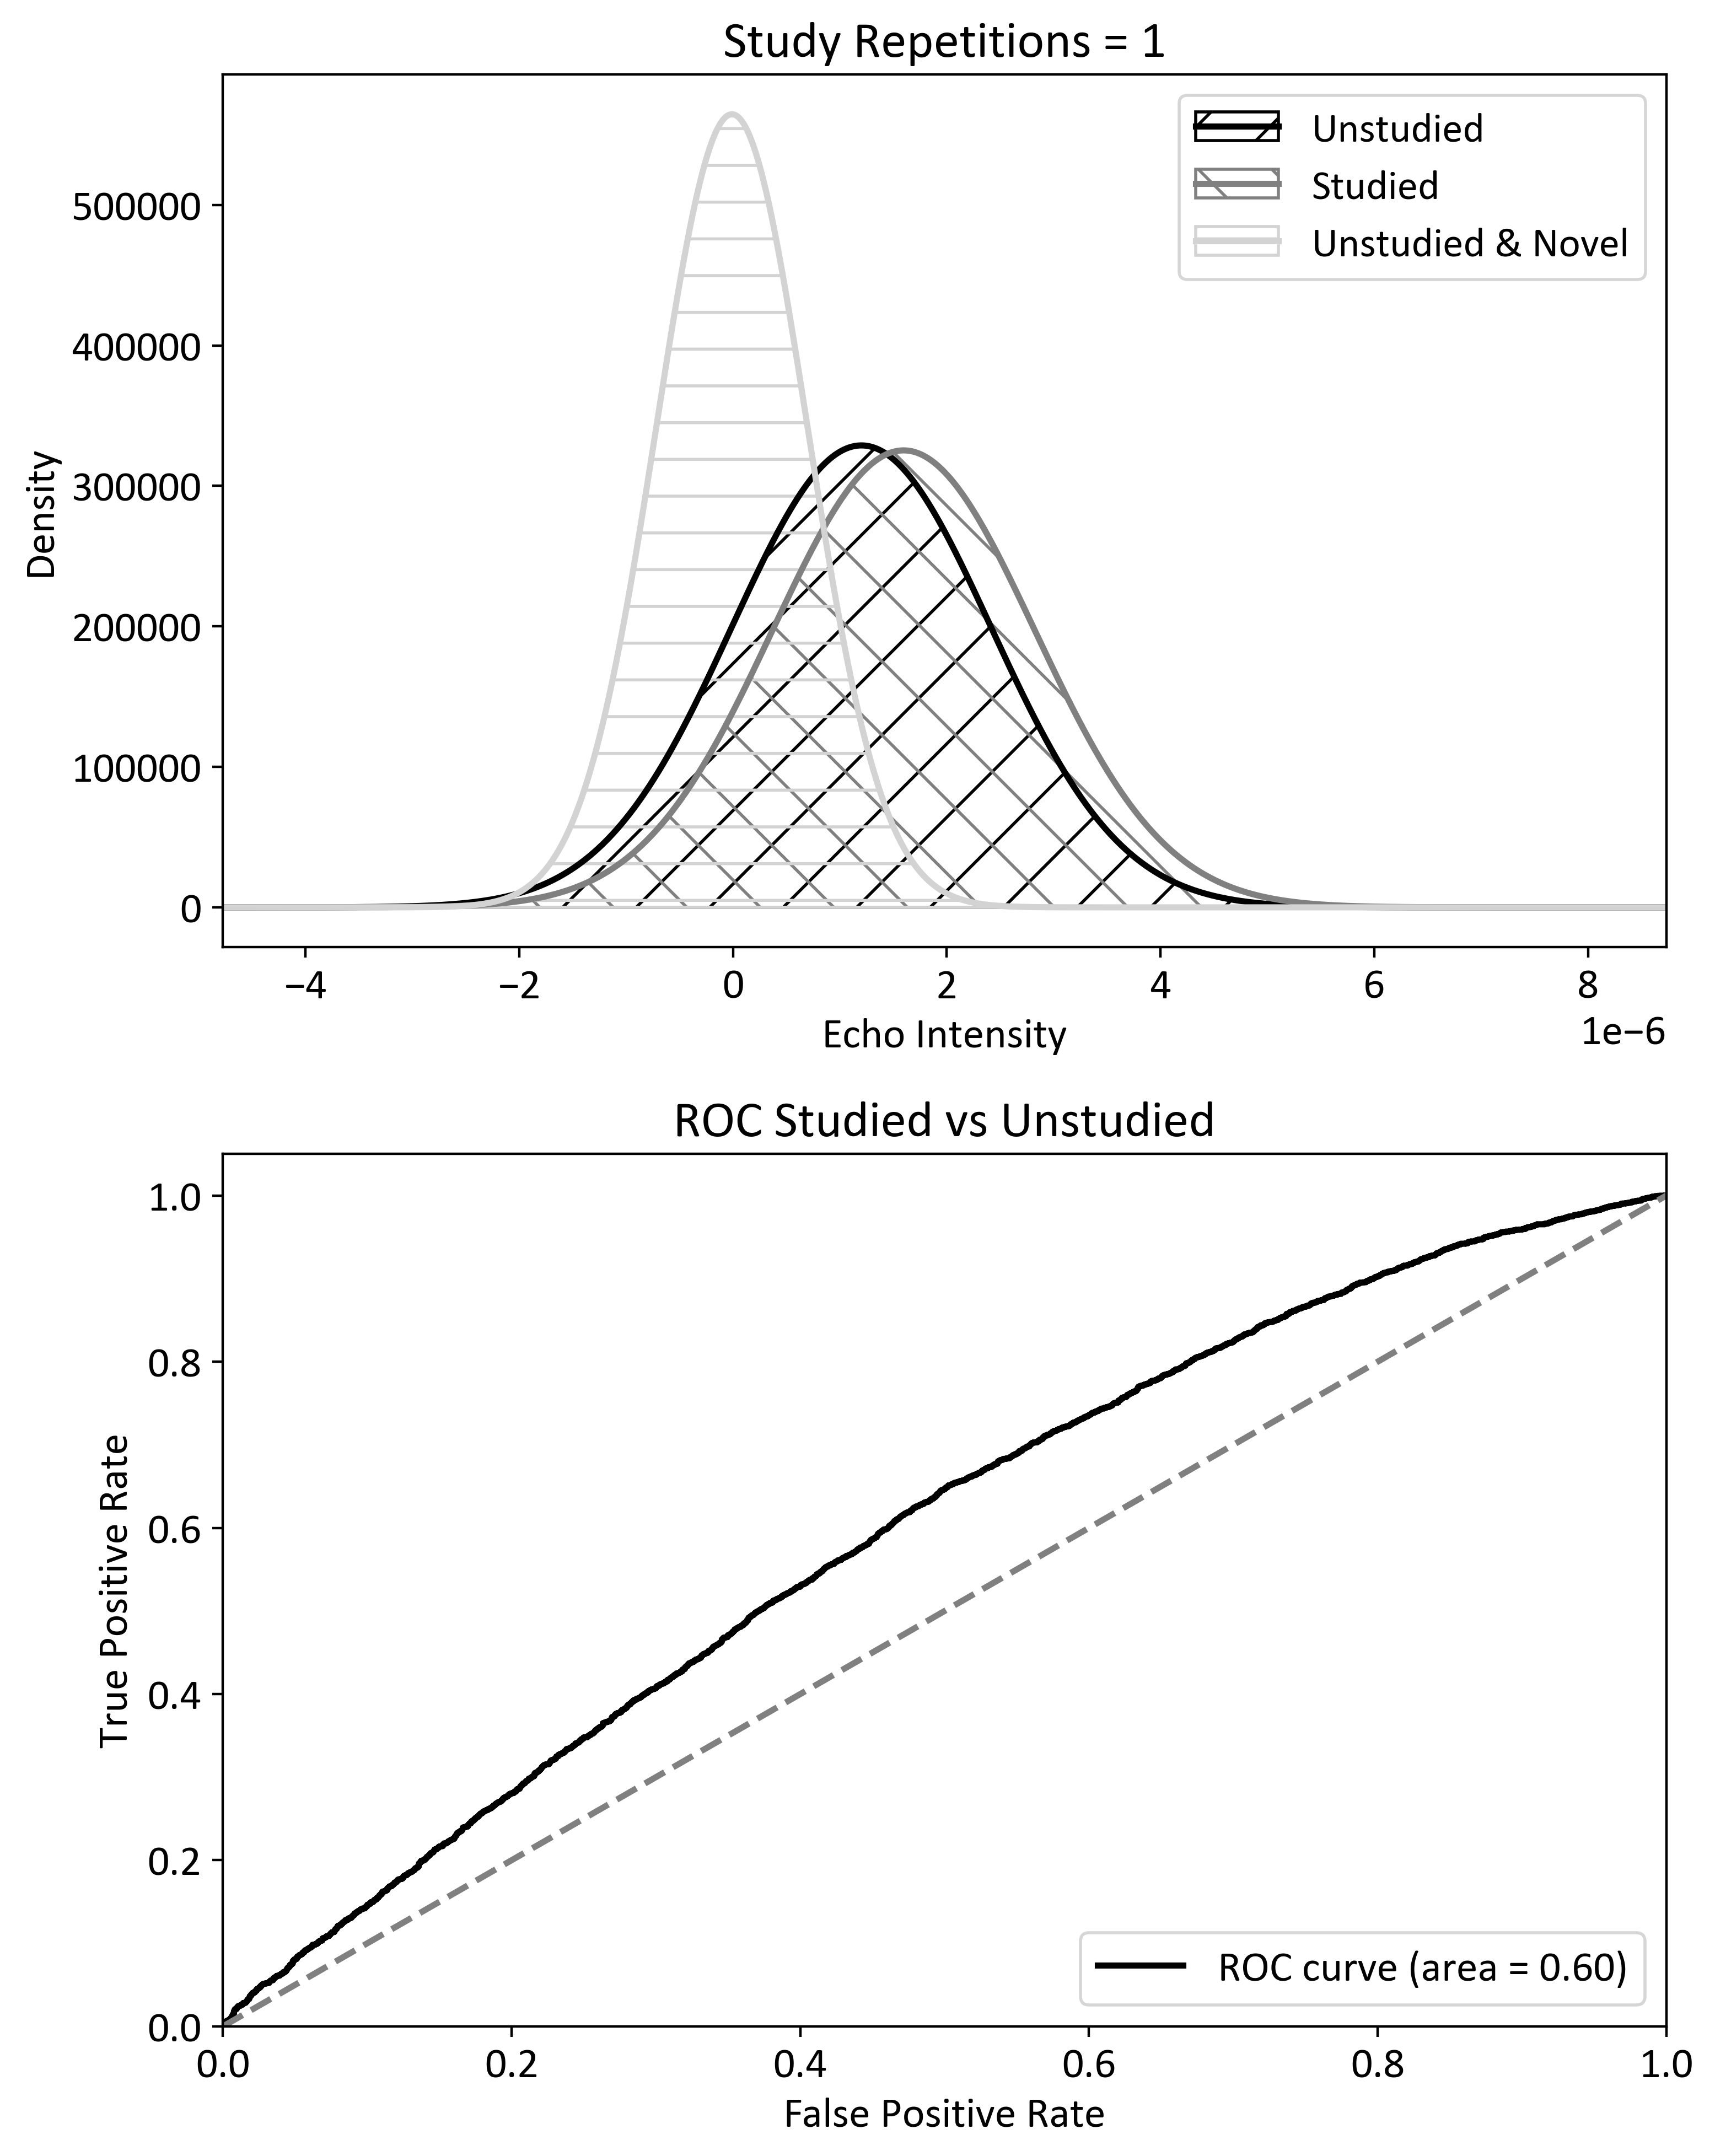

Accuracy: 0.5742
Sensitivity 0.6508
Specificity 0.4976
d-prime 0.32409992965369855


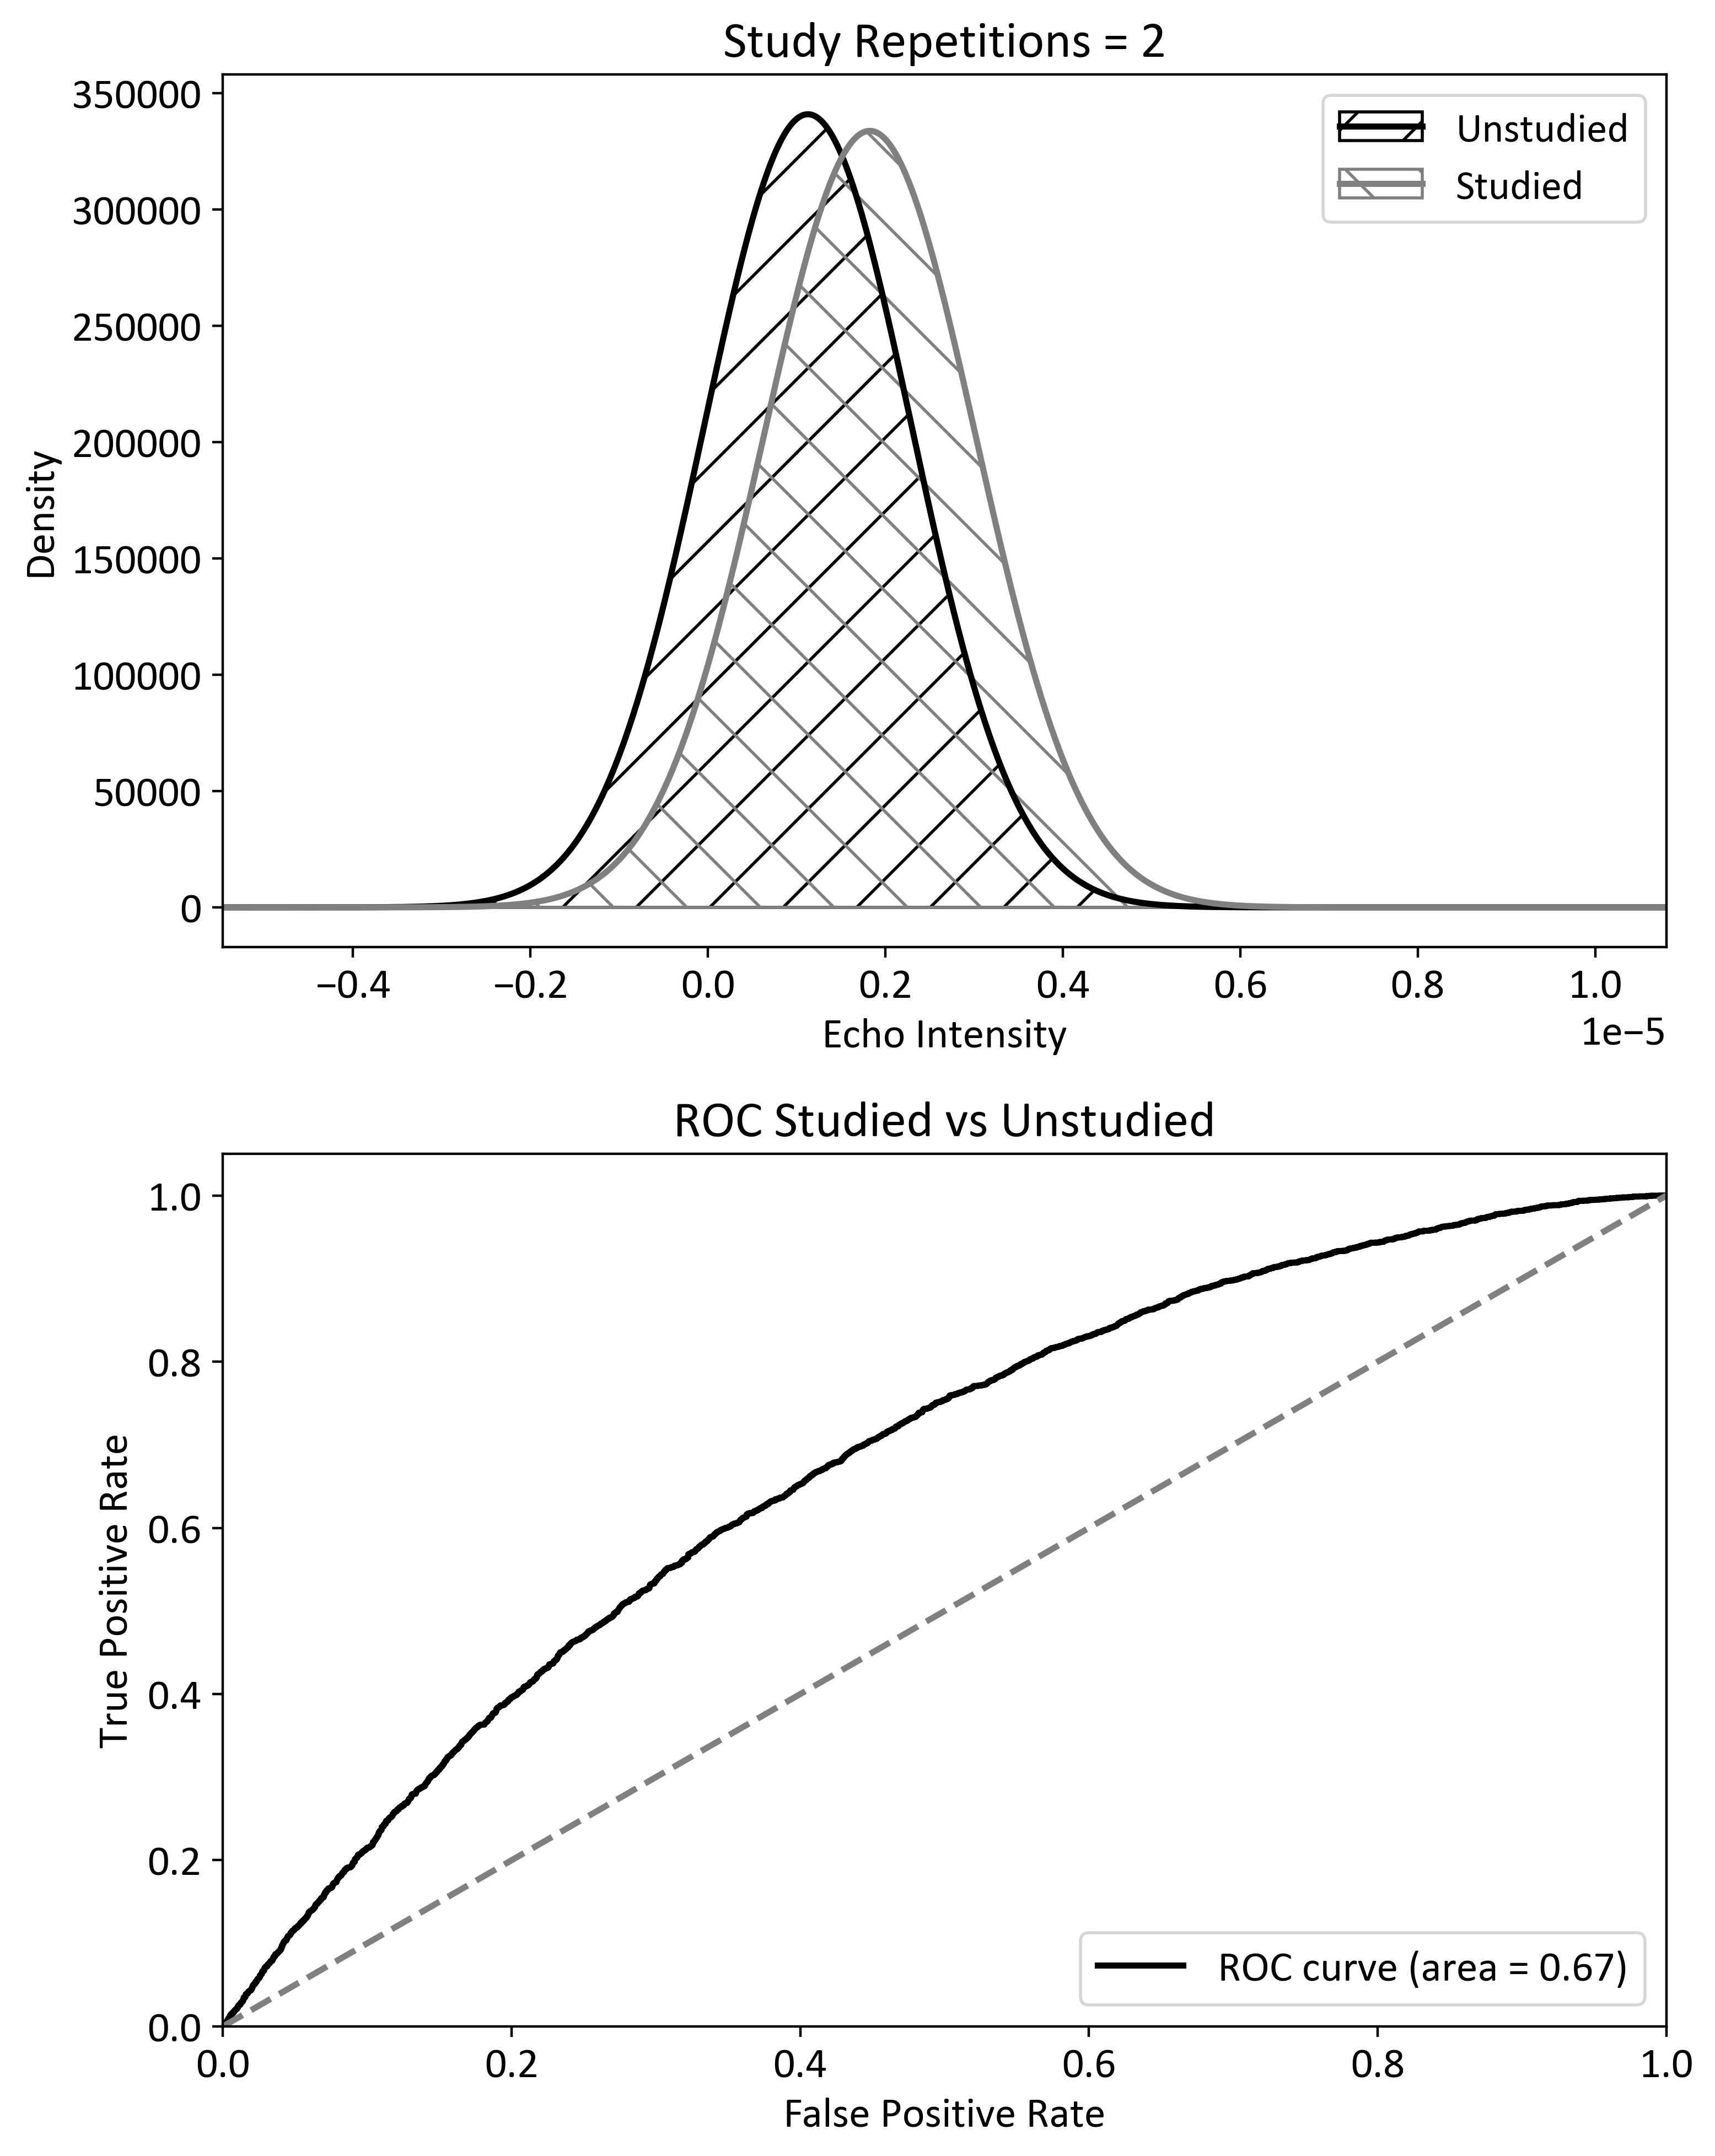

Accuracy: 0.6288
Sensitivity 0.6942
Specificity 0.5634
d-prime 0.5897118282538517


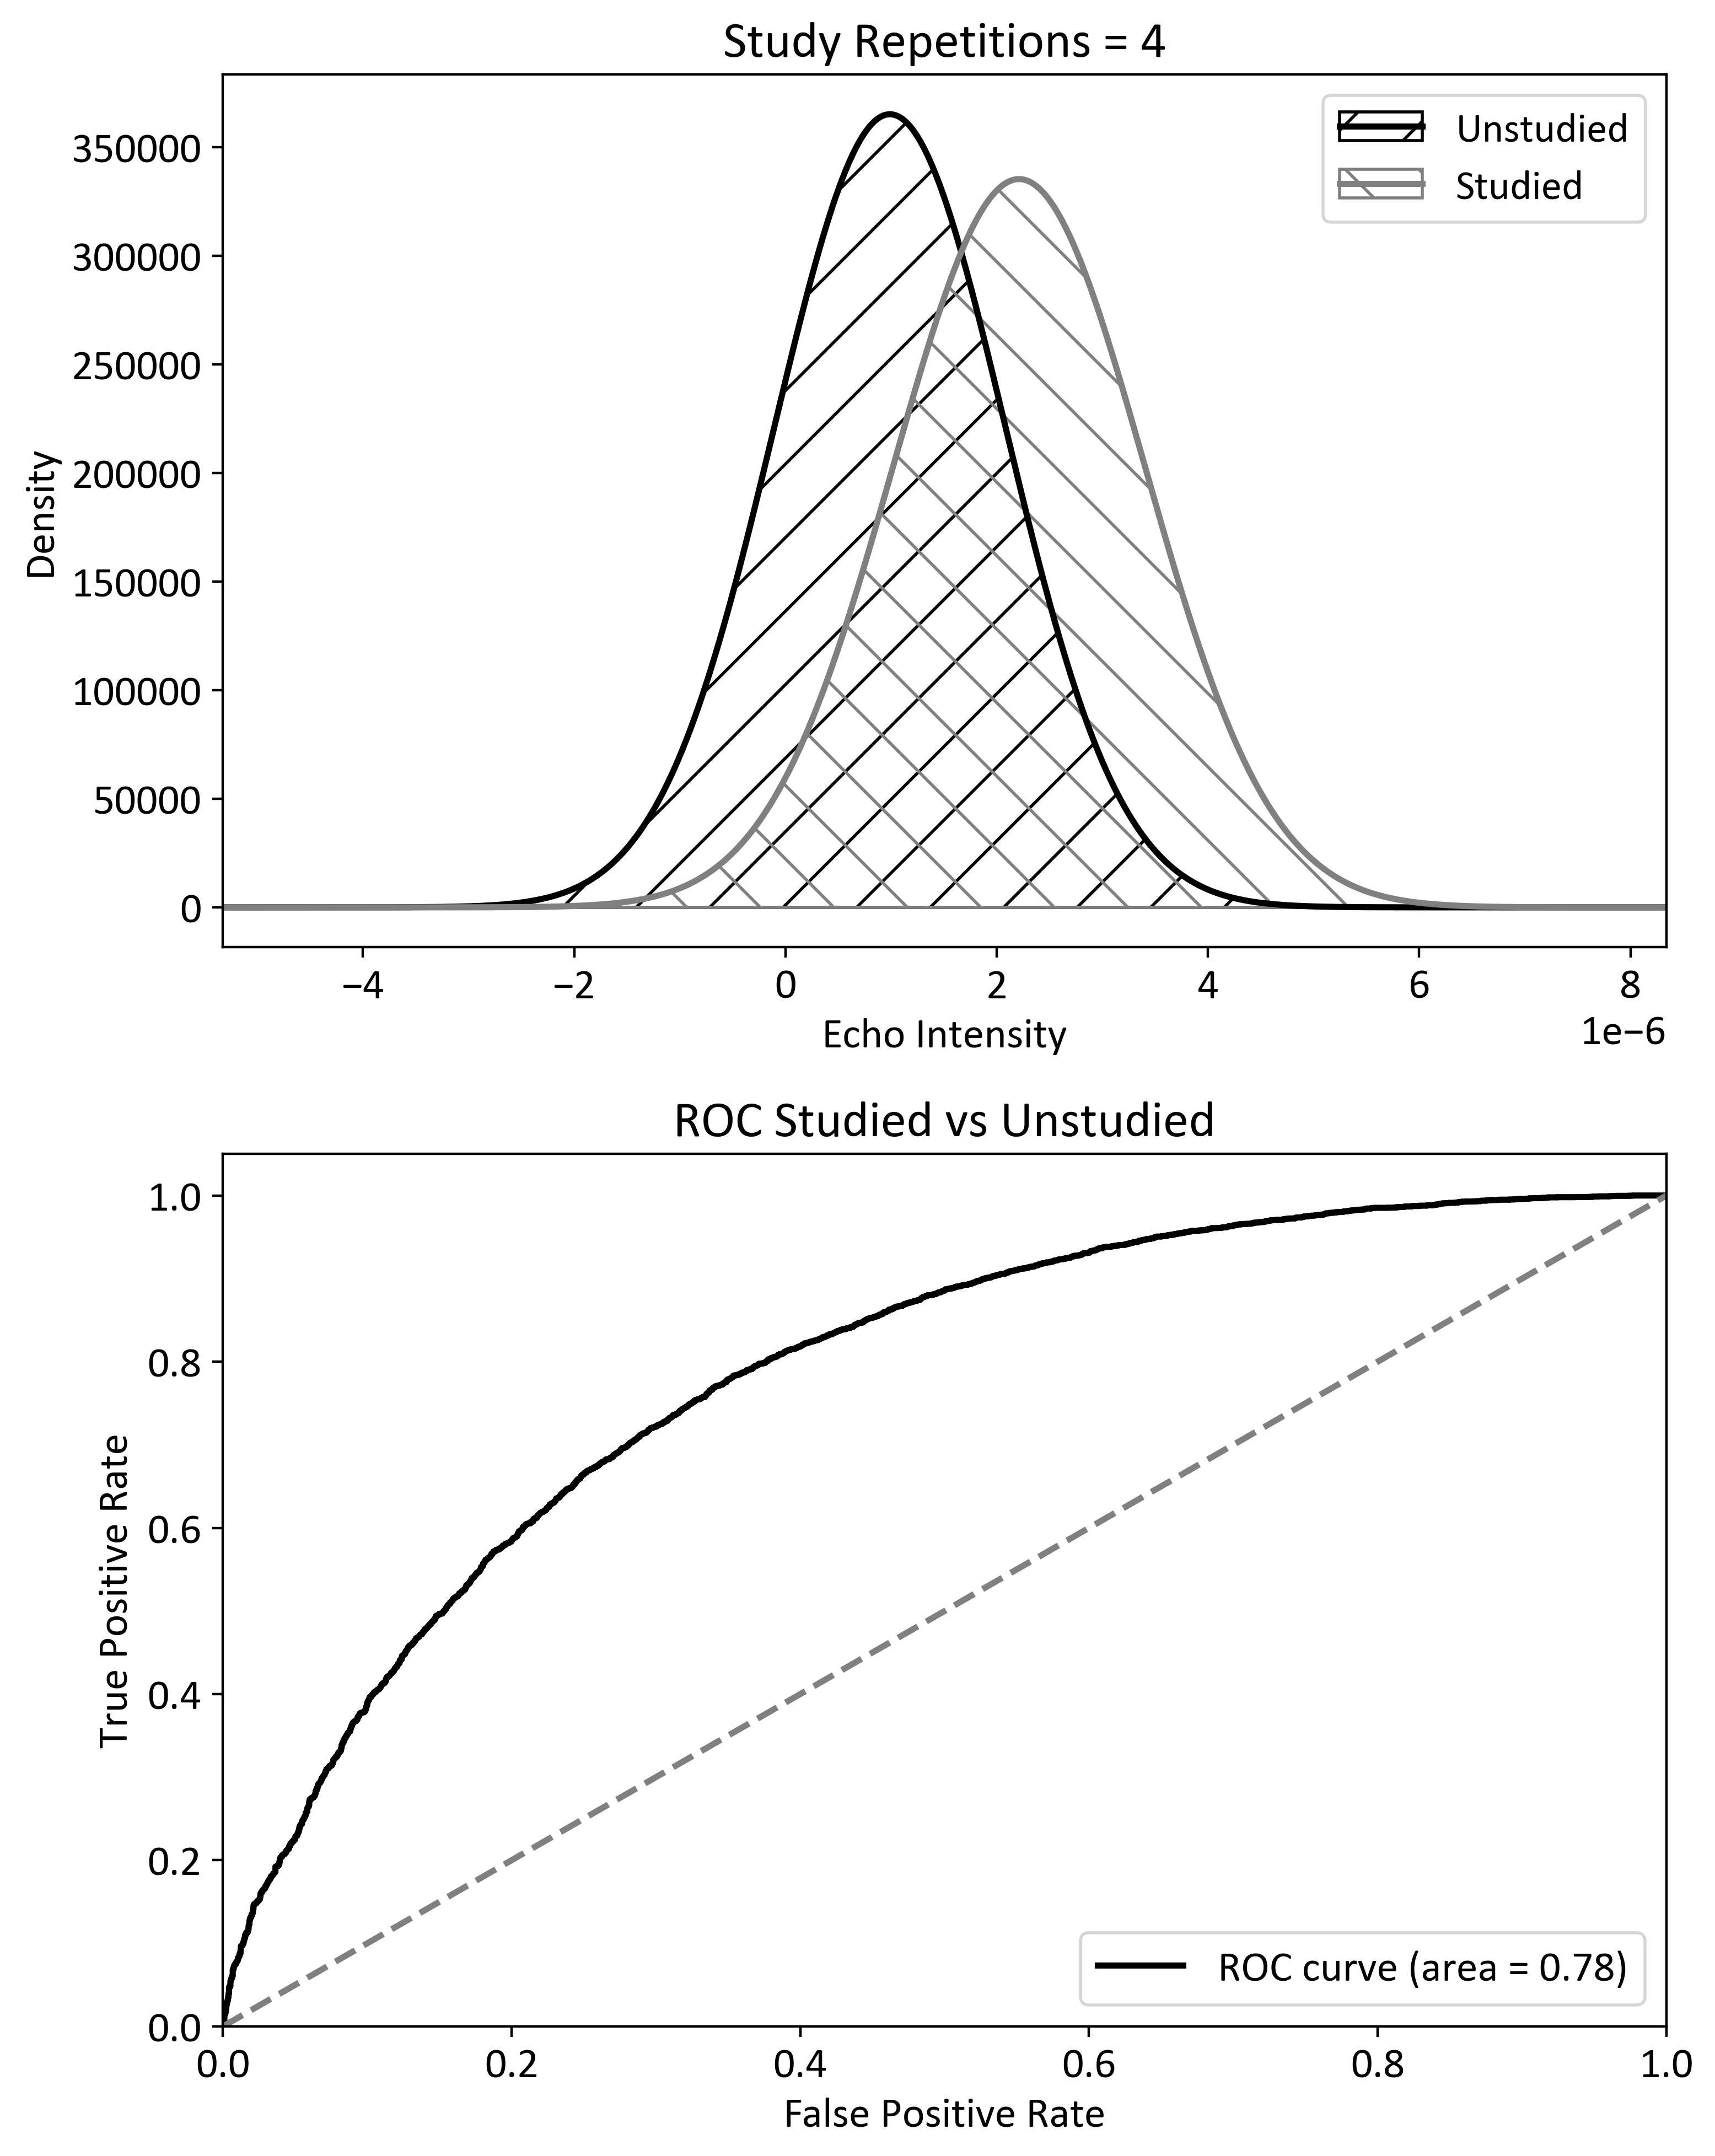

Accuracy: 0.7147
Sensitivity 0.783
Specificity 0.6464
d-prime 1.0700794043117052


In [92]:
all_data = []
for FPT in [200]:
    for sd in [7]:
        for sr in [.5]:
            for trace_noise_KB in [0.5]:
                for trace_noise_study in [0.4]:
                    for probe_noise in [0.3]:
                        for prototypes in [10000]:
                            for N_study_repetitions, show_novel_intensities in [(1, True), (2, False), (4, False)]:
                                _, unstudied_intensities, studied_intensities = PreKnowledge_Experiment(
                                    FPT = FPT,
                                    N_PROTOTYPES = prototypes,
                                    rep_mean = 1,
                                    rep_sd = sd,
                                    study_ratio = sr,
                                    trace_noise_ratio_KB = trace_noise_KB,
                                    trace_noise_ratio_study = trace_noise_study,
                                    probe_noise_ratio = probe_noise,
                                    N_study_repetitions = N_study_repetitions,
                                    show_novel_intensities = show_novel_intensities)
                                all_data.append((N_study_repetitions, unstudied_intensities, studied_intensities))

Text(0, 0.5, 'Density')

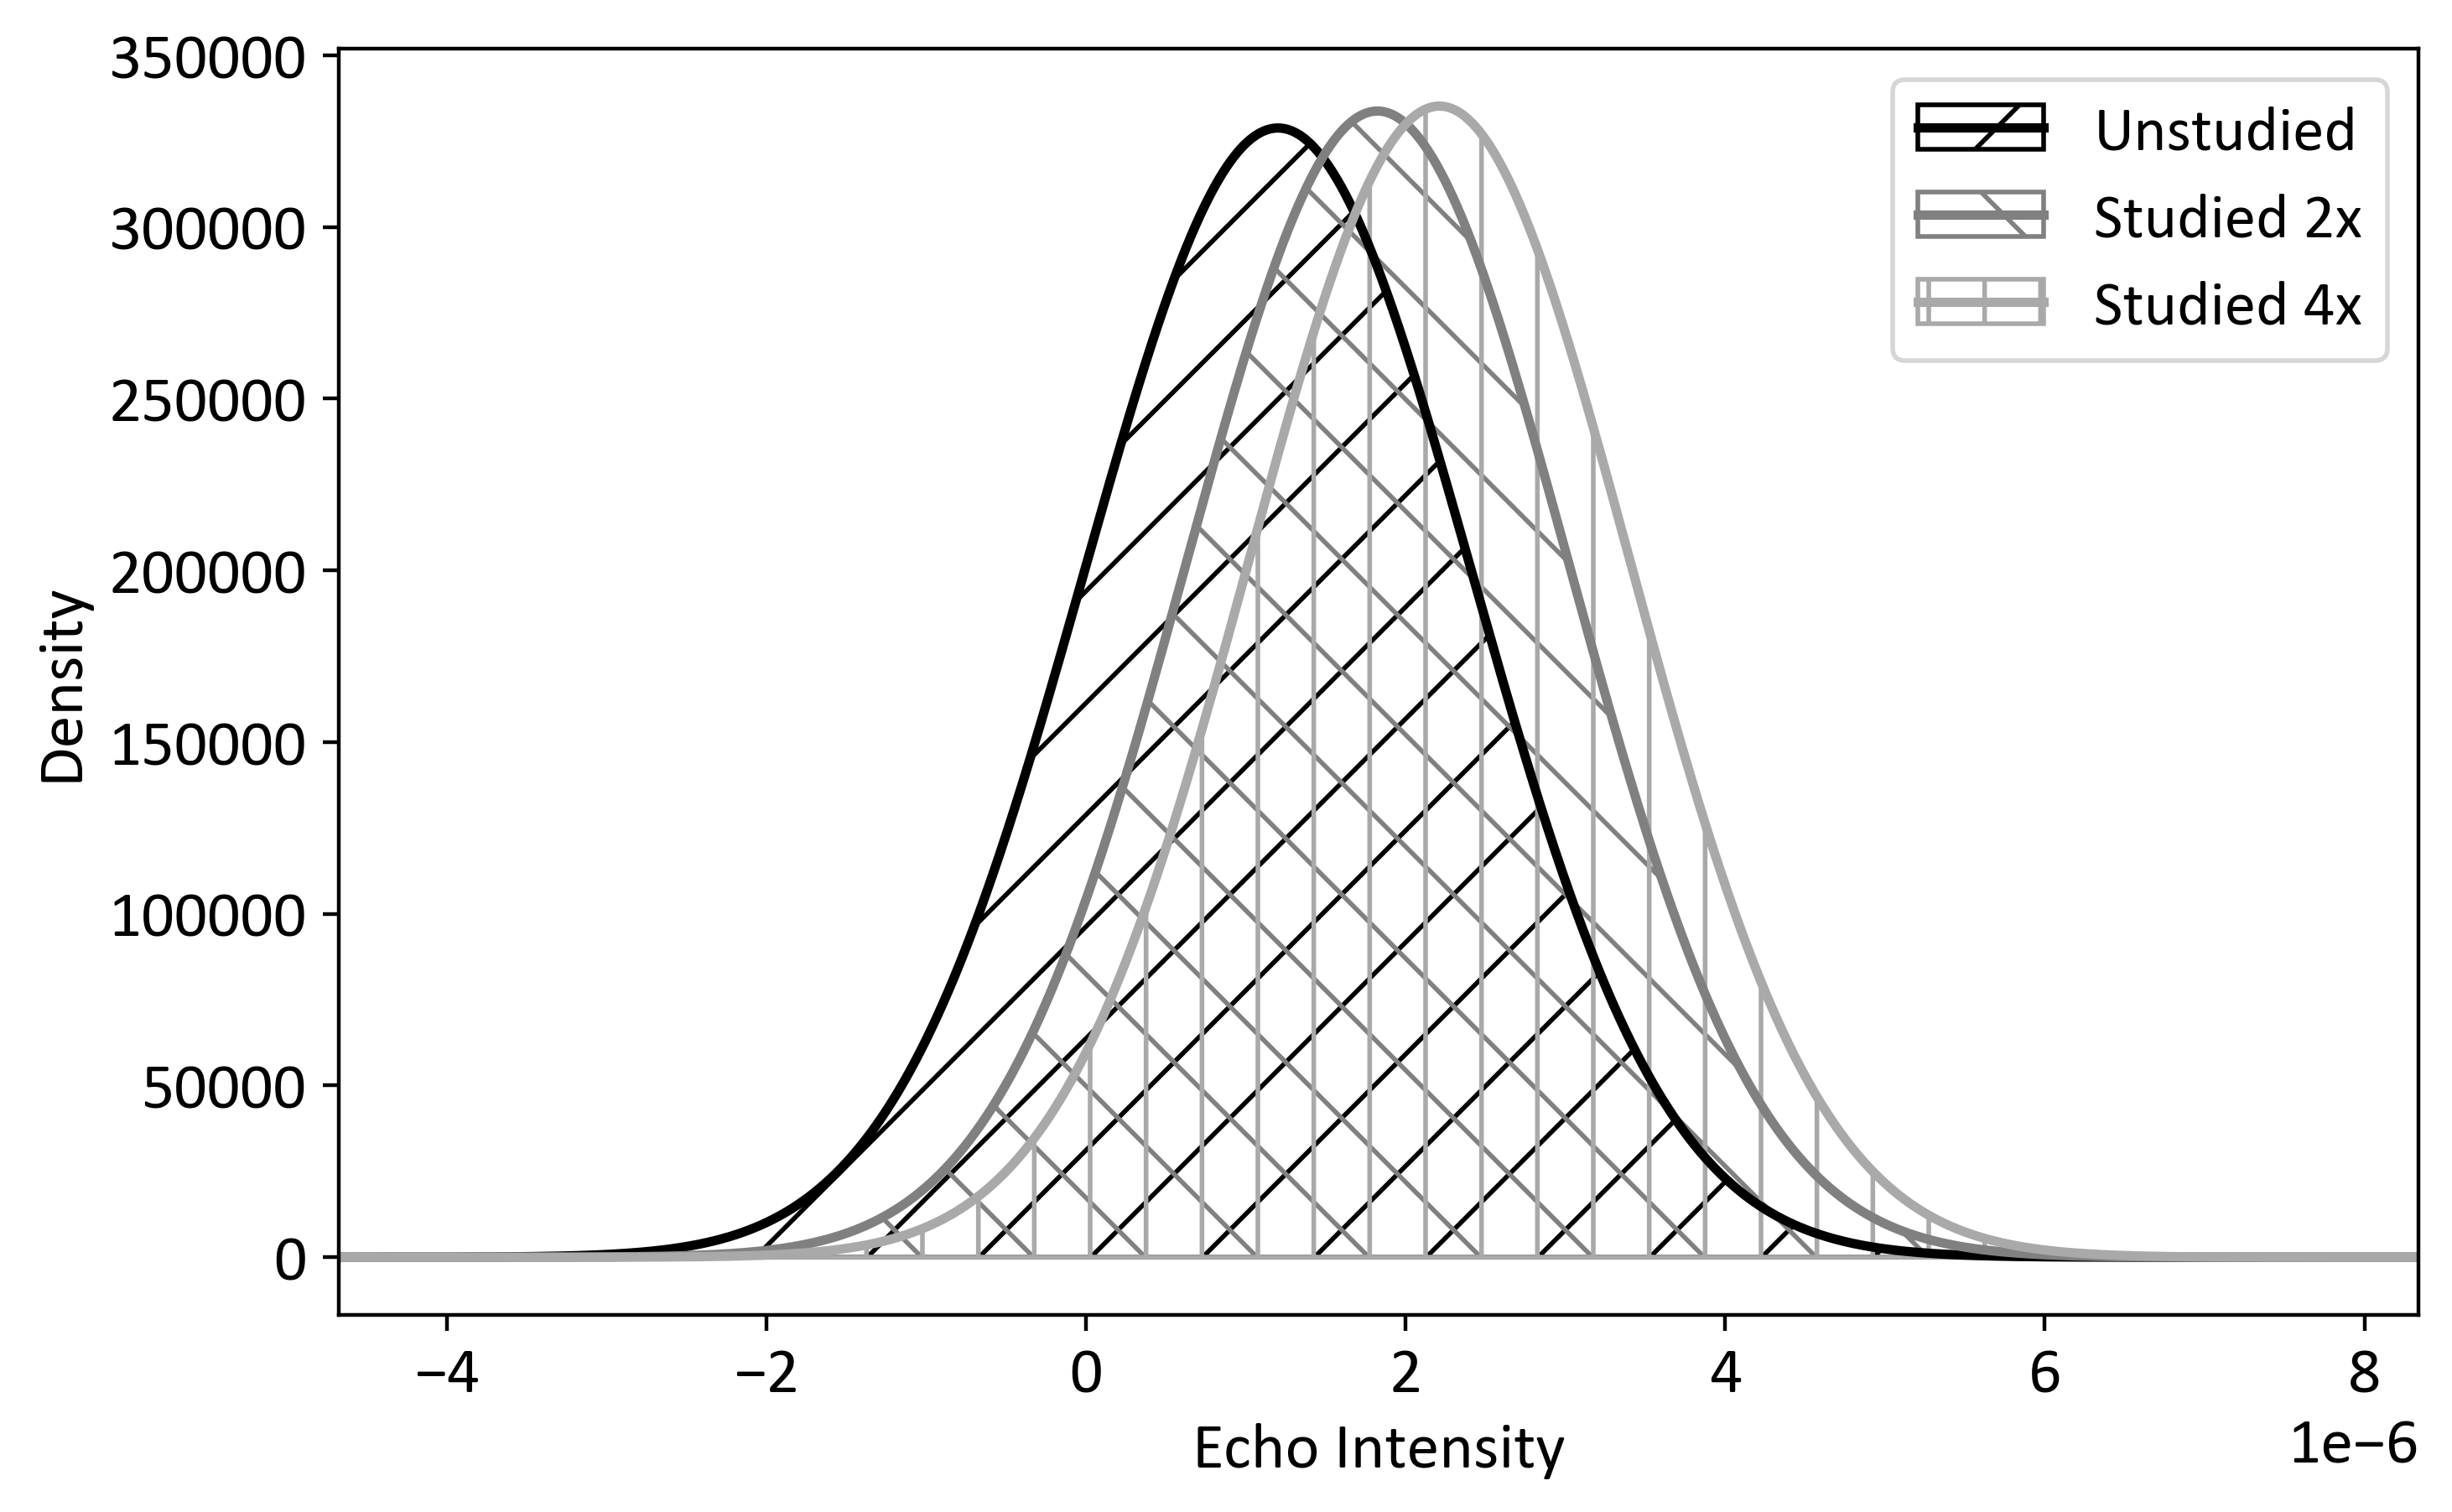

In [93]:
# show combined plot
from itertools import cycle
hatches = cycle([ "\\", "|"])
colors = cycle(["gray", "darkgray"])

unstudied_intensities = all_data[0][1]
fig, ax1 = plt.subplots(1,1, figsize=(8,5), dpi=400)
xmin = min(np.min(unstudied_intensities), np.min(studied_intensities))
xmax = max(np.max(unstudied_intensities), np.max(studied_intensities))
xmin, xmax = ax1.set_xlim(xmin - ((xmax-xmin) / 4), xmax)
x = np.linspace(xmin, xmax, 10000)
#plt.ylim(0, 6000)

mu_unstudied, std_unstudied = norm.fit(unstudied_intensities)
P_unstudied = norm.pdf(x, mu_unstudied, std_unstudied)
#plt.plot(x, P_unstudied, 'k',linewidth=4)
plt_u = ax1.plot(x, P_unstudied, 'black',linewidth=2)#: $\mu$ = {:.1e}, $\sigma$ = {:.1e}'.format(mu_unstudied, std_unstudied))
plt_u_fill = ax1.fill_between(x, P_unstudied, np.zeros_like(x), edgecolor='black', facecolor=(0,0,0,0), hatch='/')
plt_u_label ='Unstudied'

plts = [plt_u[0]]
plt_fills = [plt_u_fill]
plt_labels = [plt_u_label]
for N, _, studied_intensities in all_data[1:]:
    mu_studied, std_studied = norm.fit(studied_intensities)
    P_studied = norm.pdf(x, mu_studied, std_studied)
    color = next(colors)
    plt_s = ax1.plot(x, P_studied, color=color,linewidth=2,)#: $\mu$ = {:.1e}, $\sigma$ = {:.1e}'.format(mu_studied, std_studied))
    plt_s_fill = ax1.fill_between(x, P_studied, np.zeros_like(x), edgecolor=color, facecolor=(0,0,0,0), hatch=next(hatches))
    plt_s_label = 'Studied {}x'.format(N)
    
    plts.append(plt_s[0])
    plt_fills.append(plt_s_fill)
    plt_labels.append(plt_s_label)

ax1.legend( zip(plts, plt_fills), plt_labels, loc=1, prop={'size':13.5})
#ax1.set_title("Study Repetitions = {}".format(N_study_repetitions))
ax1.set_xlabel("Echo Intensity")
ax1.set_ylabel("Density")

In [15]:
def PreKnowledge_Experiment(FPT, 
    N_PROTOTYPES,
    rep_mean,
    rep_sd,
    study_ratio,
    trace_noise_ratio_KB,
    trace_noise_ratio_study,
    probe_noise_ratio,
    N_study_repetitions=1,
    show_novel_intensities=False):
#These are the parameters for number of features, number of traces, and repetitions

    model = Minerva2(FPT)

    #Creating the preexisting knowledge traces
    T_knowledge = np.random.randint(-1,2,(N_PROTOTYPES, FPT))

    normed_reps = np.random.normal(loc=0,scale=rep_sd,size=N_PROTOTYPES)

    for i in range(len(normed_reps)):
        normed_reps[i] = int(abs(round(normed_reps[i]) + rep_mean))
        
    normed_reps = normed_reps.astype(np.int)    

    # repeat each trace a given number of times and add it to the model
    T_repeated = np.repeat(T_knowledge, normed_reps, axis=0)
    model.add_traces(T_repeated, trace_noise_ratio_KB)

    #Randomly select subset of the T_Knowledge traces
    T_studied_indices = np.random.choice(T_knowledge.shape[0],size=int(N_PROTOTYPES*study_ratio),replace=False)
    T_studied = T_knowledge[T_studied_indices]

    #Assigning subset of T_knowledge traces to be either studied or unstudied
    T_unstudied_indices = [i for i in range(len(T_knowledge)) if i not in T_studied_indices]
    T_unstudied = T_knowledge[T_unstudied_indices]

    #add studied traces to model
    for _ in range(N_study_repetitions):
        model.add_traces(T_studied, trace_noise_ratio_study)

    #Get echo intensities
    studied_intensities = model.get_echo_intensities(T_studied, probe_noise_ratio)
    unstudied_intensities = model.get_echo_intensities(T_unstudied, probe_noise_ratio)

    #Graph echo intensities
    mu_studied, std_studied = norm.fit(studied_intensities)
    mu_unstudied, std_unstudied = norm.fit(unstudied_intensities)

    #plt.hist(unstudied_intensities, color='xkcd:green', density=True)
    #plt.hist(studied_intensities, color='xkcd:blue', density=True)

    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(4,5), dpi=400)
    xmin = min(np.min(unstudied_intensities), np.min(studied_intensities))
    xmax = max(np.max(unstudied_intensities), np.max(studied_intensities))
    xmin, xmax = ax1.set_xlim(xmin - ((xmax-xmin) / 4), xmax)
    x = np.linspace(xmin, xmax, 10000)
    #plt.ylim(0, 6000)

    
    P_studied = norm.pdf(x, mu_studied, std_studied)
    #plt.plot(x, P_studied, color='k',linewidth=4)
    plt_s = ax1.plot(x, P_studied, color='gray',linewidth=2, label='Studied')#: $\mu$ = {:.1e}, $\sigma$ = {:.1e}'.format(mu_studied, std_studied))
    plt_s_fill = ax1.fill_between(x, P_studied, np.zeros_like(x), edgecolor='gray', facecolor=(0,0,0,0), hatch='\\')
    plt_s_label = 'Studied'
    
#I swapped P_studied and Unstudied here

    P_unstudied = norm.pdf(x, mu_unstudied, std_unstudied)
    #plt.plot(x, P_unstudied, 'k',linewidth=4)
    plt_u = ax1.plot(x, P_unstudied, 'black',linewidth=2)#: $\mu$ = {:.1e}, $\sigma$ = {:.1e}'.format(mu_unstudied, std_unstudied))
    plt_u_fill = ax1.fill_between(x, P_unstudied, np.zeros_like(x), edgecolor='black', facecolor=(0,0,0,0), hatch='/')
    plt_u_label ='Unstudied'
    
    if show_novel_intensities:
        novel_traces = np.random.randint(-1,2,(N_PROTOTYPES//2, FPT))
        novel_intensities = model.get_echo_intensities(novel_traces, probe_noise_ratio)
        mu_novel, std_novel = norm.fit(novel_intensities)
        P_novel = norm.pdf(x, mu_novel, std_novel)
        plt_n = ax1.plot(x, P_novel, color='lightgray', linewidth=2)
        plt_n_fill = ax1.fill_between(x, P_novel, np.zeros_like(x), edgecolor='lightgray', facecolor=(0,0,0,0), hatch='-')
        plt_n_label = 'Unstudied & Novel'
        ax1.legend( [(plt_s[0], plt_s_fill), (plt_u[0], plt_u_fill), (plt_n[0], plt_n_fill)], 
            (plt_s_label, plt_u_label, plt_n_label),
            loc=1, prop={'size':13.5})
    else:
        ax1.legend( [(plt_s[0], plt_s_fill), (plt_u[0], plt_u_fill)], 
            (plt_s_label, plt_u_label),
            loc=1, prop={'size':13.5})
    
    #plt.title("SD={},StudiedRatio={},TraceNoise={},ProbeNoise={},#Prototypes={},#StudyReps={}".format(rep_sd, study_ratio, trace_noise_ratio, probe_noise_ratio,N_PROTOTYPES, N_study_repetitions))
    ax1.set_title("Study Repetitions = {}".format(N_study_repetitions))
    ax1.set_xlabel("Echo Intensity")
    ax1.set_ylabel("Density")
    
    
    # ROC analysis
    y_labels = np.vstack((np.ones_like(studied_intensities.reshape(-1,1)), np.zeros_like(unstudied_intensities.reshape(-1,1))))
    y_values = np.vstack((studied_intensities.reshape(-1,1), unstudied_intensities.reshape(-1,1)))
    fpr, tpr, thresholds = roc_curve(y_labels, y_values)
    roc_auc = auc(fpr, tpr)
    ax2.plot(fpr, tpr, color='black',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    ax2.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Studied vs Unstudied')
    ax2.legend(loc="lower right")
    fig.tight_layout()
    plt.show()
    
    # calculate accuracy (dirty)
    best_threshold_idx = np.argmax([get_accuracy(threshold, y_values, y_labels, needs_flipped=True) 
                             for threshold in thresholds])
    accuracy = get_accuracy(thresholds[best_threshold_idx], y_values, y_labels, needs_flipped=True)
    print('Accuracy:', accuracy)
    sensitivity = np.sum(studied_intensities > thresholds[best_threshold_idx]) / len(studied_intensities) 
    print('Sensitivity', sensitivity)
    specificity = np.sum(unstudied_intensities <= thresholds[best_threshold_idx]) / len(unstudied_intensities)
    print('Specificity', specificity)
    
    # calculate d-prime
    d_prime = get_dprime(mu_studied, mu_unstudied, std_studied, std_unstudied)
    print('d-prime', d_prime)
    
    #save data
    with open("Simulations_Output_{}reps.csv".format(N_study_repetitions), 'w') as file:
        file.write("unstudied,studied\n")
        for u,s in zip(unstudied_intensities, studied_intensities):
            file.write('{},{}\n'.format(u, s))
              
    return x, unstudied_intensities, studied_intensities
    

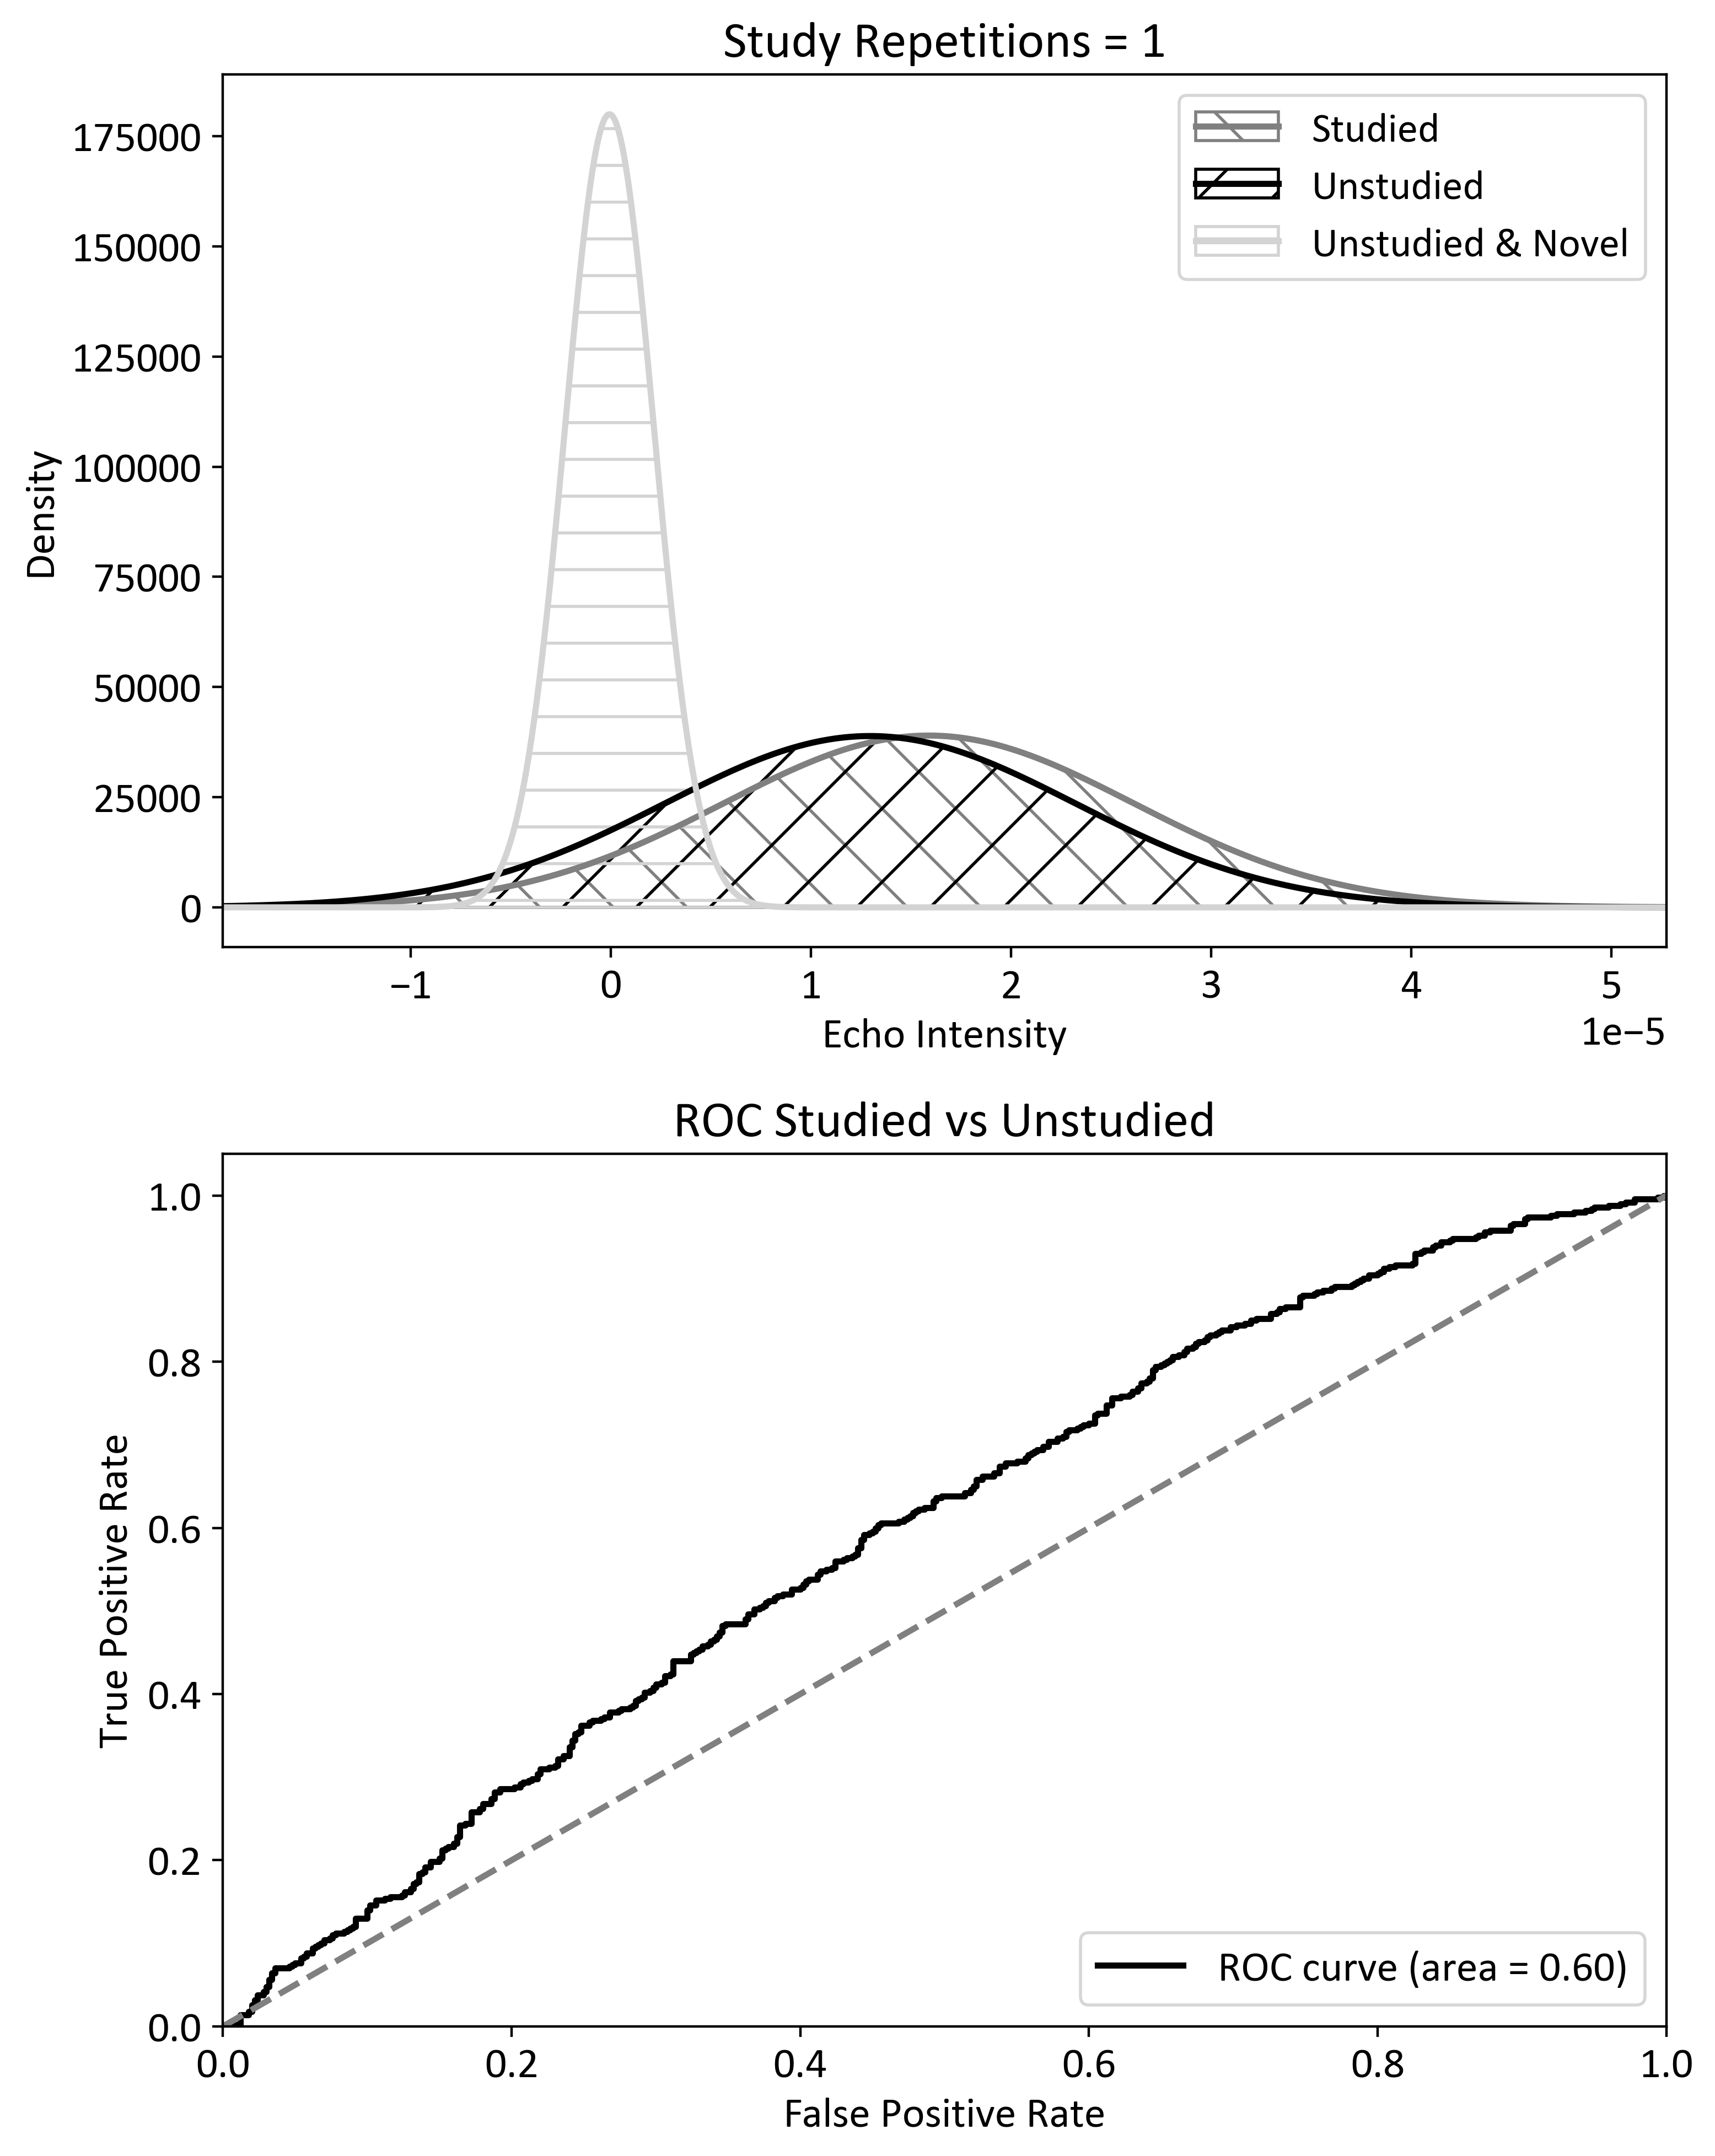

Accuracy: 0.575
Sensitivity 0.604
Specificity 0.546
d-prime 0.28542590333754086


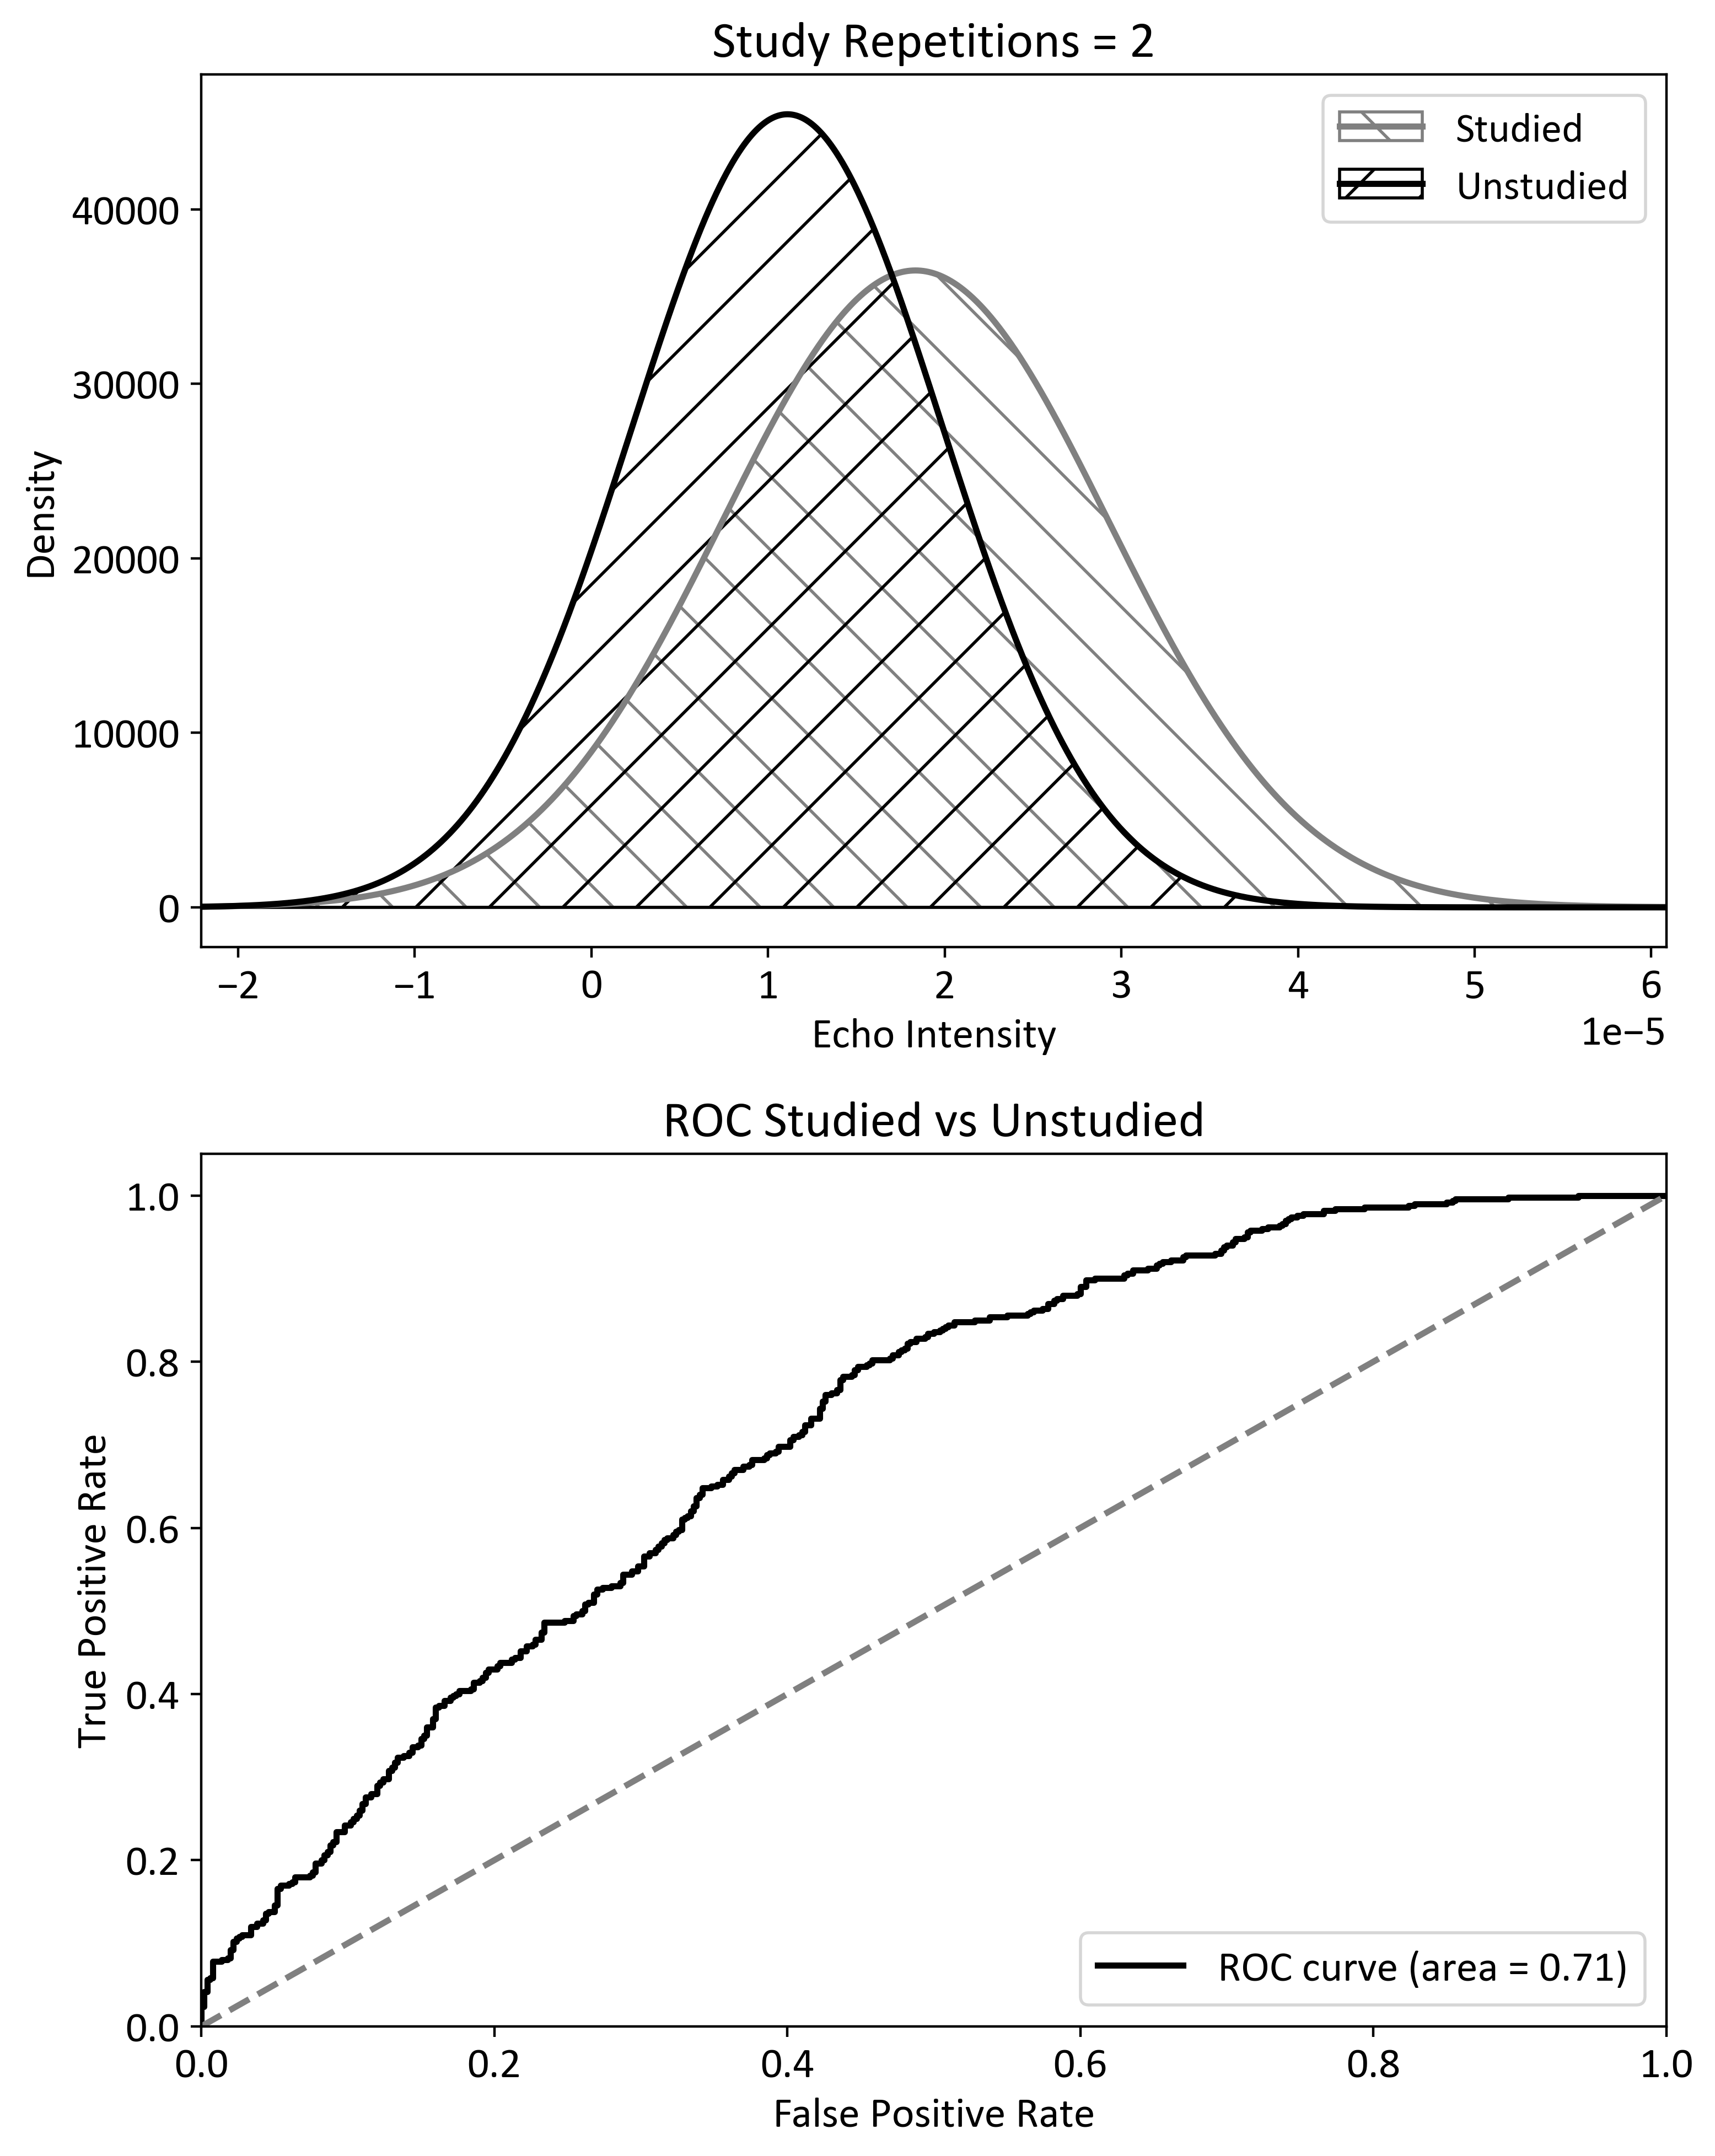

Accuracy: 0.672
Sensitivity 0.79
Specificity 0.554
d-prime 0.7314402179280465


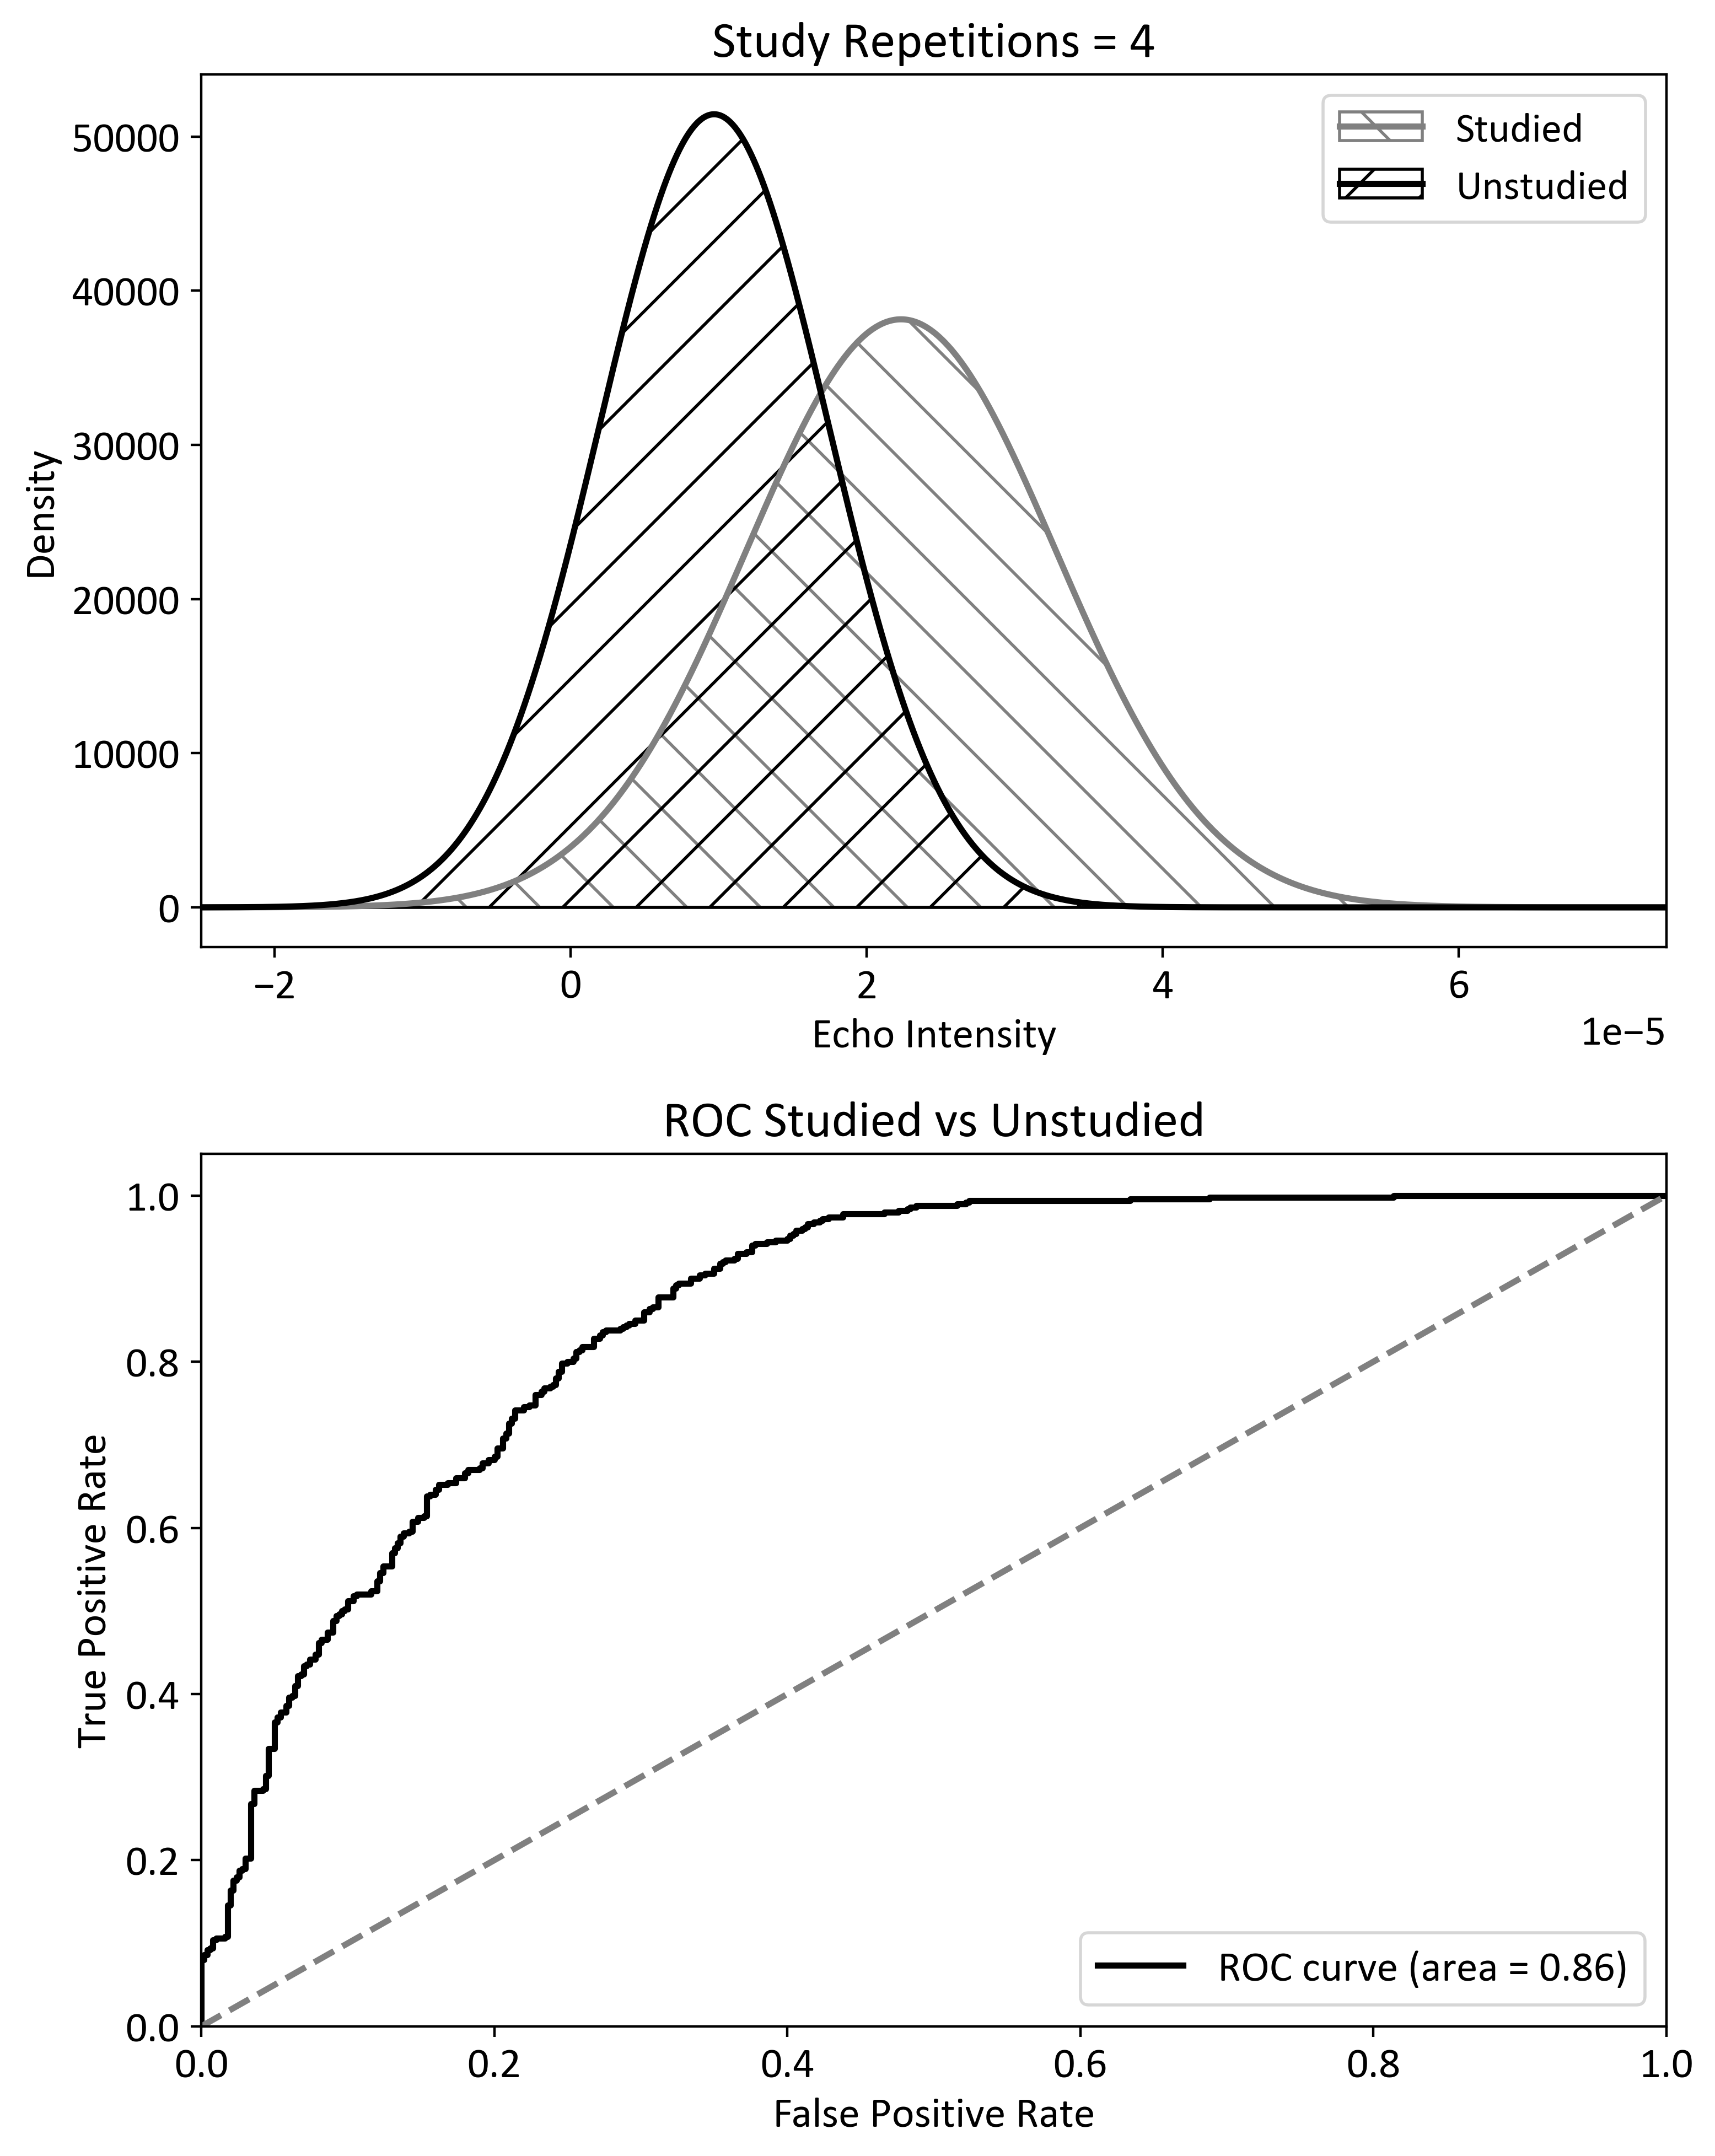

Accuracy: 0.784
Sensitivity 0.892
Specificity 0.676
d-prime 1.371362971960962


In [25]:
all_data = []
for FPT in [200]:
    for sd in [7]:
        for sr in [.5]:
            for trace_noise_KB in [0.5]:
                for trace_noise_study in [0.4]:
                    for probe_noise in [0.3]:
                        for prototypes in [1000]:
                            for N_study_repetitions, show_novel_intensities in [(1, True), (2, False), (4, False)]:
                                _, unstudied_intensities, studied_intensities = PreKnowledge_Experiment(
                                    FPT = FPT,
                                    N_PROTOTYPES = prototypes,
                                    rep_mean = 1,
                                    rep_sd = sd,
                                    study_ratio = sr,
                                    trace_noise_ratio_KB = trace_noise_KB,
                                    trace_noise_ratio_study = trace_noise_study,
                                    probe_noise_ratio = probe_noise,
                                    N_study_repetitions = N_study_repetitions,
                                    show_novel_intensities = show_novel_intensities)
                                all_data.append((N_study_repetitions, unstudied_intensities, studied_intensities))

In [16]:
#Trying to make the simulation generate three conditions at once: x0, x2, and x4
def PreKnowledge_Experiment(FPT, 
    N_PROTOTYPES,
    rep_mean,
    rep_sd,
    study_ratio,
    trace_noise_ratio_KB,
    trace_noise_ratio_study,
    probe_noise_ratio,
    N_study_repetitions_few,
    N_study_repetitions_many,
    show_novel_intensities=False):
#These are the parameters for number of features, number of traces, and repetitions


    model = Minerva2(FPT)

    #Creating the preexisting knowledge traces
    T_knowledge = np.random.randint(-1,2,(N_PROTOTYPES, FPT))

    normed_reps = np.random.normal(loc=0,scale=rep_sd,size=N_PROTOTYPES)

    for i in range(len(normed_reps)):
        normed_reps[i] = int(abs(round(normed_reps[i]) + rep_mean))
        
    normed_reps = normed_reps.astype(np.int)    
    
#     import matplotlib.pyplot as plt

#     plt.hist(normed_reps, bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5])

    # for each trace in KB
#     for t in range(T_knowledge.shape[0]):
#         # add each trace based on rep weight
#         for _ in range(normed_reps[t]):
#             #add to model
#             model.add_trace(T_knowledge[t], trace_noise_ratio)

    # repeat each trace a given number of times and add it to the model
    T_repeated = np.repeat(T_knowledge, normed_reps, axis=0)
    model.add_traces(T_repeated, trace_noise_ratio_KB)

    #Randomly select subset of the T_Knowledge traces to be STUDIEDx2
    T_studiedx2_indices = np.random.choice(T_knowledge.shape[0],size=int(N_PROTOTYPES*study_ratio),replace=False)
    T_studiedx2 = T_knowledge[T_studiedx2_indices]

    #Assigning subset of T_knowledge traces to be either STUDIEDx4
    T_studiedx4_indices = [i for i in range(len(T_knowledge)) if i not in T_studiedx2_indices]
    T_studiedx4 = T_knowledge[T_studiedx4_indices]
     
    #Assigning subset of T_knowledge traces to be unstudied
    T_unstudied_indices = [i for i in range(len(T_knowledge)) if i not in T_studiedx2_indices or T_studiedx4_indices]
    T_unstudied = T_knowledge[T_unstudied_indices]

    #add studied traces to model
    for _ in range(N_study_repetitions_few):
        model.add_traces(T_studiedx2, trace_noise_ratio_study)
    for _ in range(N_study_repetitions_many):
        model.add_traces(T_studiedx4, trace_noise_ratio_study)

    #Get echo intensities
    studiedx2_intensities = model.get_echo_intensities(T_studiedx2, probe_noise_ratio)
    studiedx4_intensities = model.get_echo_intensities(T_studiedx4, probe_noise_ratio)
    unstudied_intensities = model.get_echo_intensities(T_unstudied, probe_noise_ratio)

    #Graph echo intensities
    mu_studiedx2, std_studiedx2 = norm.fit(studiedx2_intensities)
    mu_studiedx4, std_studiedx4 = norm.fit(studiedx4_intensities)
    mu_unstudied, std_unstudied = norm.fit(unstudied_intensities)

    #plt.hist(unstudied_intensities, color='xkcd:green', density=True)
    #plt.hist(studied_intensities, color='xkcd:blue', density=True)

    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,10), dpi=400)
    xmin = min(np.min(unstudied_intensities), np.min(studiedx4_intensities))
    xmax = max(np.max(unstudied_intensities), np.max(studiedx4_intensities))
    xmin, xmax = ax1.set_xlim(xmin - ((xmax-xmin) / 4), xmax)
    x = np.linspace(xmin, xmax, 10000)
    #plt.ylim(0, 6000)

    
    P_studiedx2 = norm.pdf(x, mu_studiedx2, std_studiedx2)
    #plt.plot(x, P_studied, color='k',linewidth=4)
    plt_sx2 = ax1.plot(x, P_studiedx2, color='gray',linewidth=2, label='Studiedx2')#: $\mu$ = {:.1e}, $\sigma$ = {:.1e}'.format(mu_studied, std_studied))
    plt_sx2_fill = ax1.fill_between(x, P_studiedx2, np.zeros_like(x), edgecolor='gray', facecolor=(0,0,0,0), hatch='-')
    plt_sx2_label = 'Studiedx2'
    
    P_studiedx4 = norm.pdf(x, mu_studiedx4, std_studiedx4)
    #plt.plot(x, P_studied, color='k',linewidth=4)
    plt_sx4 = ax1.plot(x, P_studiedx4, color='gray',linewidth=2, label='Studiedx4')#: $\mu$ = {:.1e}, $\sigma$ = {:.1e}'.format(mu_studied, std_studied))
    plt_sx4_fill = ax1.fill_between(x, P_studiedx4, np.zeros_like(x), edgecolor='gray', facecolor=(0,0,0,0), hatch='\\')
    plt_sx4_label = 'Studiedx4'

    P_unstudied = norm.pdf(x, mu_unstudied, std_unstudied)
    #plt.plot(x, P_unstudied, 'k',linewidth=4)
    plt_u = ax1.plot(x, P_unstudied, 'black',linewidth=2)#: $\mu$ = {:.1e}, $\sigma$ = {:.1e}'.format(mu_unstudied, std_unstudied))
    plt_u_fill = ax1.fill_between(x, P_unstudied, np.zeros_like(x), edgecolor='black', facecolor=(0,0,0,0), hatch='/')
    plt_u_label ='Unstudied'
    
    
    #plt.title("SD={},StudiedRatio={},TraceNoise={},ProbeNoise={},#Prototypes={},#StudyReps={}".format(rep_sd, study_ratio, trace_noise_ratio, probe_noise_ratio,N_PROTOTYPES, N_study_repetitions))
    ax1.set_title("Study Repetitions {} vs. {}".format(N_study_repetitions_few, N_study_repetitions_many))
    ax1.set_xlabel("Echo Intensity")
    ax1.set_ylabel("Density")
    
    
    # ROC analysis
    y_labels = np.vstack((np.ones_like(studiedx2_intensities.reshape(-1,1)), np.zeros_like(unstudied_intensities.reshape(-1,1))))
    y_values = np.vstack((studiedx2_intensities.reshape(-1,1), unstudied_intensities.reshape(-1,1)))
    fpr, tpr, thresholds = roc_curve(y_labels, y_values)
    roc_auc = auc(fpr, tpr)
    ax2.plot(fpr, tpr, color='black',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    ax2.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Studied vs Unstudied')
    ax2.legend(loc="lower right")
    fig.tight_layout()
    plt.show()
    
    # calculate accuracy (dirty)
    best_threshold_idx = np.argmax([get_accuracy(threshold, y_values, y_labels, needs_flipped=True) 
                             for threshold in thresholds])
    accuracy = get_accuracy(thresholds[best_threshold_idx], y_values, y_labels, needs_flipped=True)
    print('Accuracy:', accuracy)
    sensitivity = np.sum(studiedx2_intensities > thresholds[best_threshold_idx]) / len(studiedx2_intensities) 
    print('Sensitivity', sensitivity)
    specificity = np.sum(unstudied_intensities <= thresholds[best_threshold_idx]) / len(unstudied_intensities)
    print('Specificity', specificity)
    
    # calculate d-prime
    d_prime = get_dprime(mu_studiedx2, mu_unstudied, std_studiedx2, std_unstudied)
    print('d-prime', d_prime)
    
    #save data
    with open("Simulations_Output_{}reps.csv".format(N_study_repetitions), 'w') as file:
        file.write("unstudied,studied\n")
        for u,s in zip(unstudied_intensities, studied_intensities):
            file.write('{},{}\n'.format(u, s))
              
    return x, unstudied_intensities, studiedx2_intensities, studiedx4_intensities
    

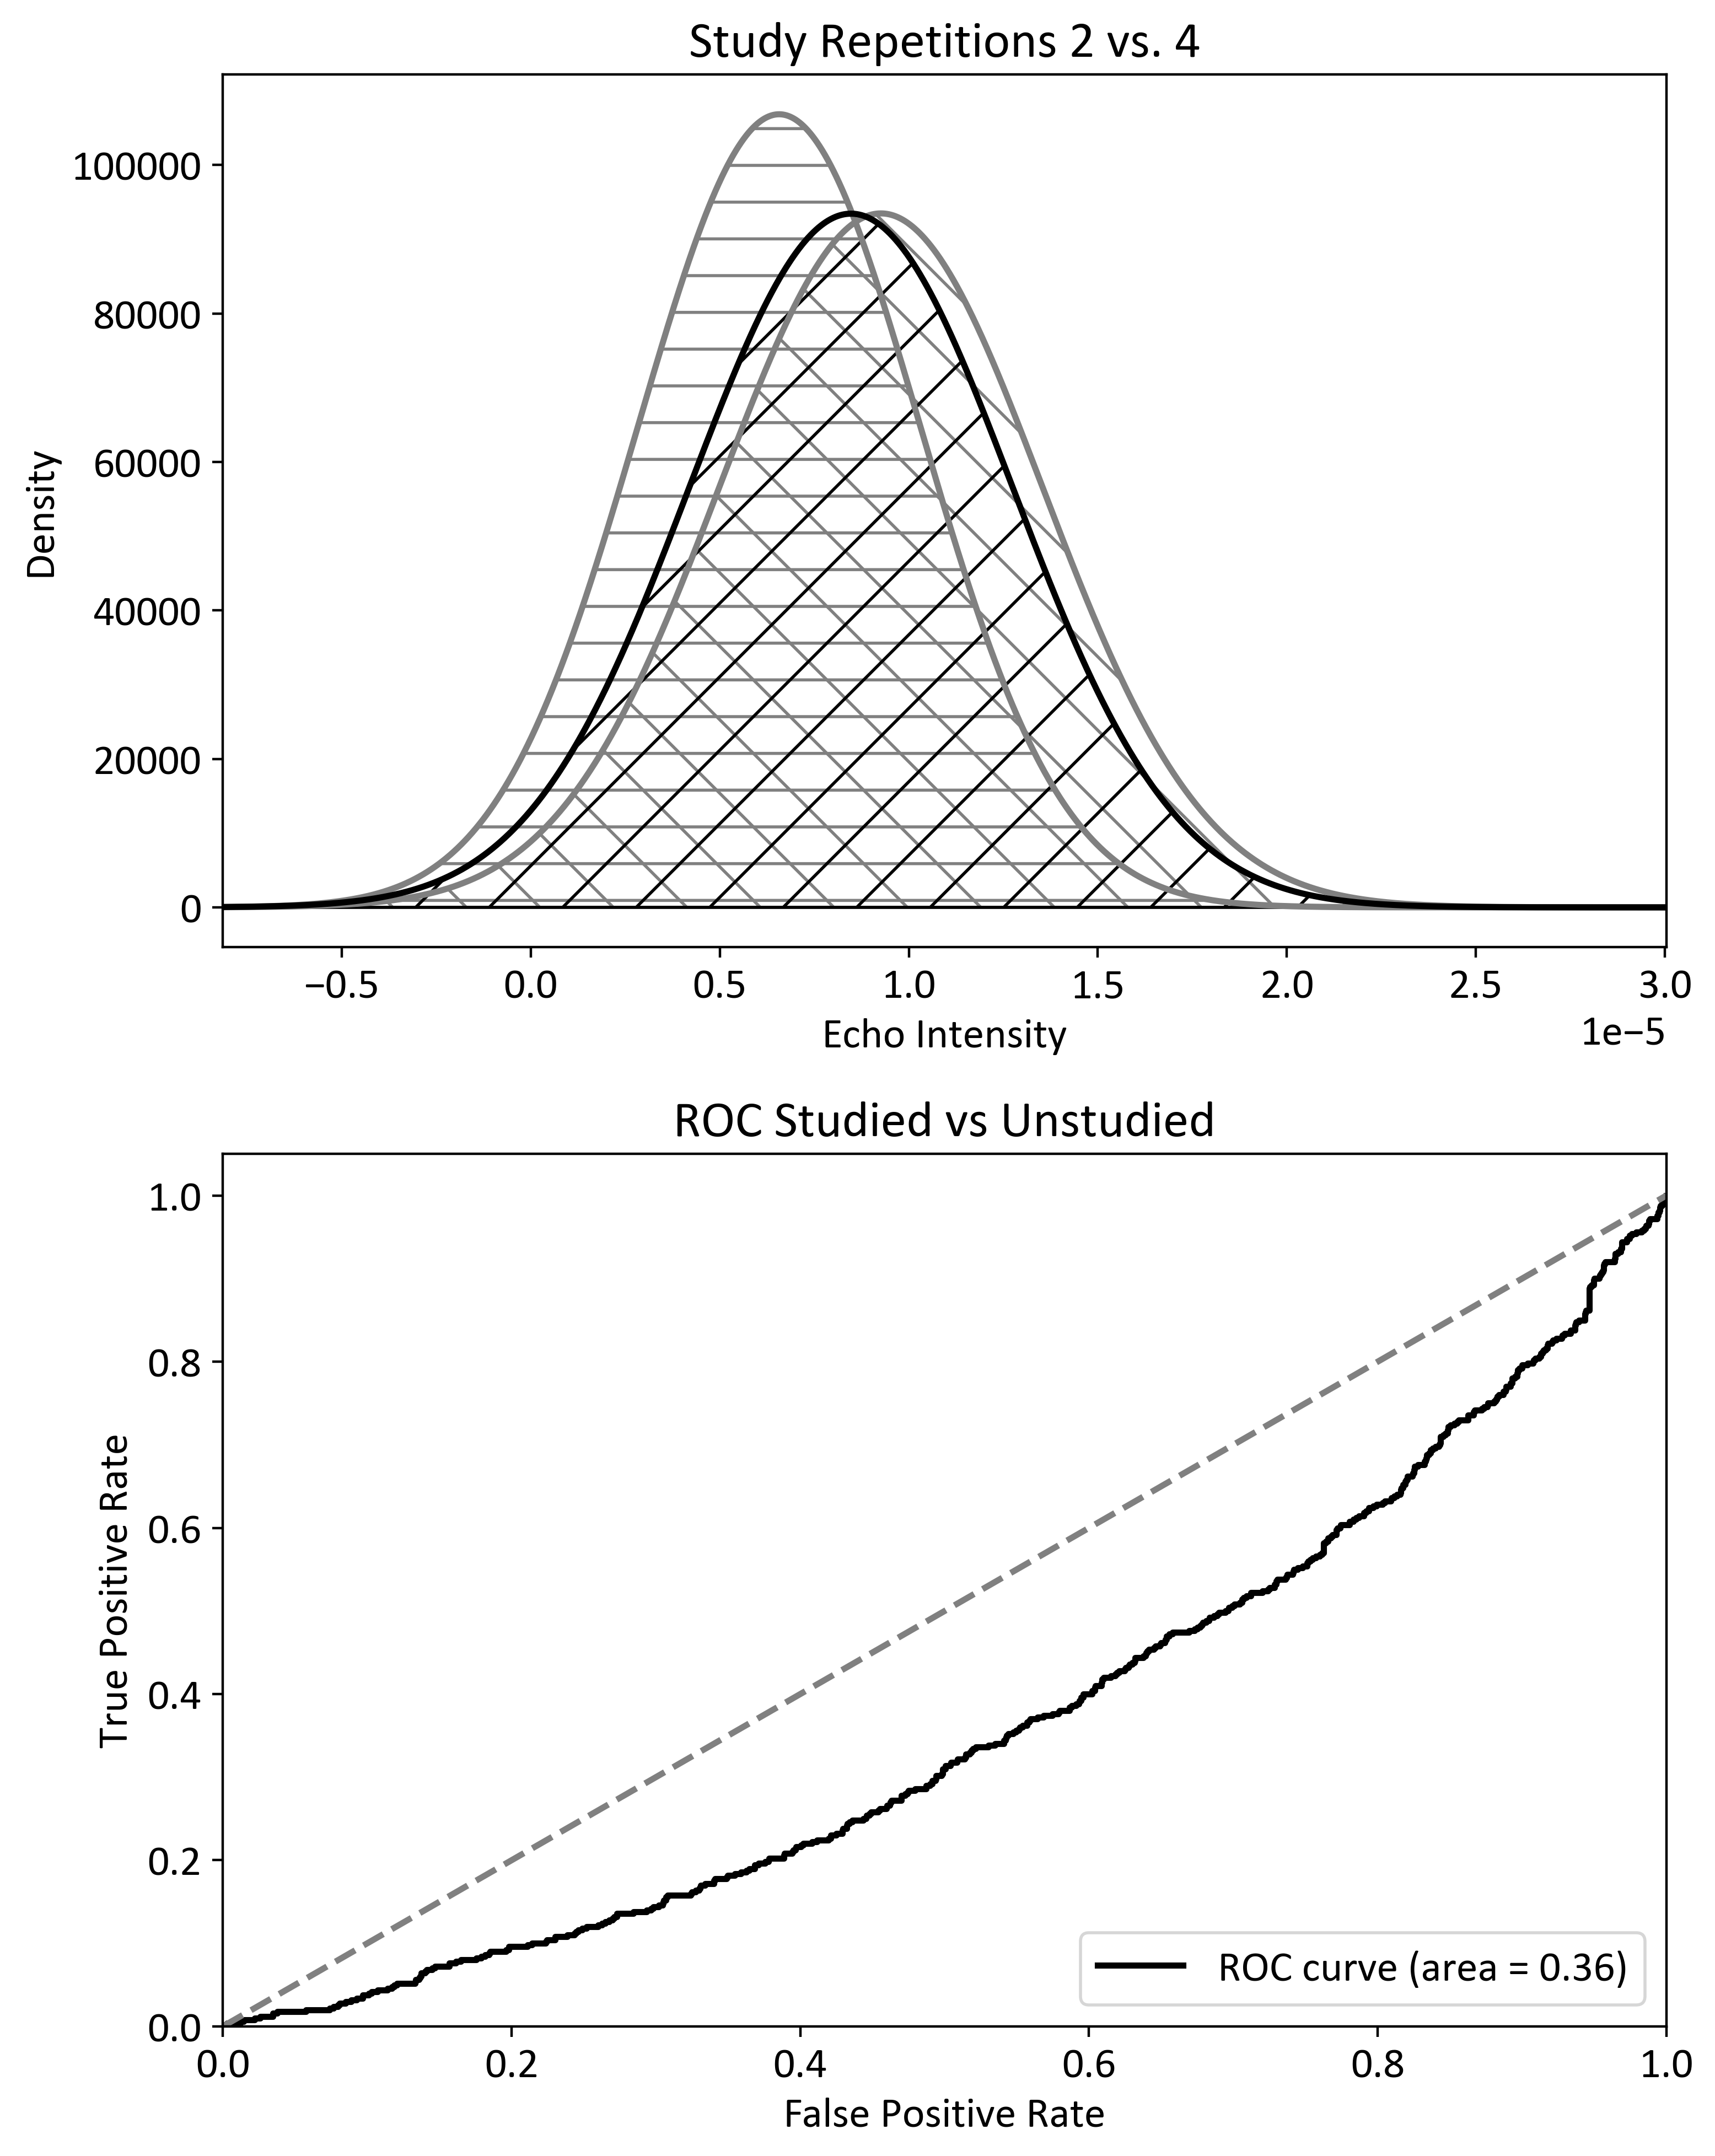

Accuracy: 0.8
Sensitivity 0.0
Specificity 1.0
d-prime -0.4737916390321759


ValueError: too many values to unpack (expected 3)

In [63]:
for FPT in [200]:
    for sd in [7]:
        for sr in [.25]:
            for trace_noise_KB in [0.5]:
                for trace_noise_study in [0.4]:
                    for probe_noise in [0.3]:
                        for prototypes in [2000]:
                            for N_study_repetitions_few in [2]:
                                for N_study_repetitions_many in [4]:
                                    unstudied_intensities, studiedx2_intensities, studiedx4_intensities = PreKnowledge_Experiment(
                                        FPT = FPT,
                                        N_PROTOTYPES = prototypes,
                                        rep_mean = 1,
                                        rep_sd = sd,
                                        study_ratio = sr,
                                        trace_noise_ratio_KB = trace_noise_KB,
                                        trace_noise_ratio_study = trace_noise_study,
                                        probe_noise_ratio = probe_noise,
                                        N_study_repetitions_few = N_study_repetitions_few,
                                        N_study_repetitions_many = N_study_repetitions_many)

# Explore parameter values

In [7]:
def get_preknowledge_data(FPT, 
    N_PROTOTYPES,
    rep_mean,
    rep_sd,
    study_ratio,
    trace_noise_ratio_KB,
    trace_noise_ratio_study,
    probe_noise_ratio,
    N_study_repetitions=1):
#These are the parameters for number of features, number of traces, and repetitions

    model = Minerva2(FPT)

    #Creating the preexisting knowledge traces
    T_knowledge = np.random.randint(-1,2,(N_PROTOTYPES, FPT))
    novel_traces = np.random.randint(-1,2,(N_PROTOTYPES//2, FPT))

    normed_reps = np.random.normal(loc=0,scale=rep_sd,size=N_PROTOTYPES)

    for i in range(len(normed_reps)):
        normed_reps[i] = int(abs(round(normed_reps[i]) + rep_mean))
        
    normed_reps = normed_reps.astype(np.int)    

    # repeat each trace a given number of times and add it to the model
    T_repeated = np.repeat(T_knowledge, normed_reps, axis=0)
    model.add_traces(T_repeated, trace_noise_ratio_KB)

    #Randomly select subset of the T_Knowledge traces
    T_studied_indices = np.random.choice(T_knowledge.shape[0],size=int(N_PROTOTYPES*study_ratio),replace=False)
    T_studied = T_knowledge[T_studied_indices]

    #Assigning subset of T_knowledge traces to be either studied or unstudied
    T_unstudied_indices = [i for i in range(len(T_knowledge)) if i not in T_studied_indices]
    T_unstudied = T_knowledge[T_unstudied_indices]

    #add studied traces to model
    for _ in range(N_study_repetitions):
        model.add_traces(T_studied, trace_noise_ratio_study)

    #Get echo intensities
    studied_intensities = model.get_echo_intensities(T_studied, probe_noise_ratio)
    unstudied_intensities = model.get_echo_intensities(T_unstudied, probe_noise_ratio)
    novel_intensities = model.get_echo_intensities(novel_traces, probe_noise_ratio)

    return novel_intensities, unstudied_intensities, studied_intensities

In [36]:
def summarize_preknowledge_data(intensities1_list, intensities2_list, colors, linestyles, title, labels, filename=None, print_data=True):
    results = []
    fig1, ax1 = plt.subplots(1,1, figsize=(6,6), dpi=400)
    
    for intensities1, intensities2, color, linestyle, label in zip(intensities1_list, intensities2_list, colors, linestyles, labels):
        print('Calculating for', label)
        y_labels = np.hstack((np.ones_like(intensities1), np.zeros_like(intensities2)))
        y_values = np.hstack((intensities1, intensities2))

        # ROC analysis
        fpr, tpr, thresholds = roc_curve(y_labels, y_values)

        # calculate optimal threshold using sensitivity/specificity (aka G-mean)
        best_threshold_idx = np.argmax(np.sqrt(tpr * (1-fpr)))
        if print_data: print('threshold:', thresholds[best_threshold_idx])
        if print_data: print('Sensitivity (TPR):', tpr[best_threshold_idx])
        if print_data: print('Specificity (1-FPR):', 1-fpr[best_threshold_idx])

        # calculate d-prime
        mu_1, std_1 = norm.fit(intensities1)
        mu_2, std_2 = norm.fit(intensities2)
        d_prime = get_dprime(mu_1, mu_2, std_1, std_2)
        if print_data: print('d-prime', d_prime)
        
        # draw curve
        roc_auc = auc(fpr, tpr)
        ax1.plot(fpr, tpr, color=color, linestyle=linestyle,
                 lw=2, label='{} (AUC {:.2f})'.format(label, roc_auc))
        #ax1.scatter([fpr[best_threshold_idx]], [tpr[best_threshold_idx]], color='red')
        
        results.append((tpr[best_threshold_idx], 1-fpr[best_threshold_idx], d_prime, roc_auc))
        
    ax1.plot([0, 1], [0, 1], color='lightgrey', lw=2, linestyle='--', label='Chance')
    ax1.set_xlim([-0.01, 1.0])
    ax1.set_ylim([-0.01, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title(title)
    ax1.legend(loc="lower right", prop={'size':10})
    plt.tight_layout()
    if filename and len(filename) > 0:
        plt.savefig(filename, dpi=400)
    plt.show()
    
    return results

In [46]:
def plot_preknowledge_data(intensities_lists, colors_list, hatches_list, labels_list, title, xlabel, ylabel, filename=None):
    # get range
    xmin = min([min(intensities_list) for intensities_list in intensities_lists])
    xmax = max([max(intensities_list) for intensities_list in intensities_lists])
    xmin -= (xmax-xmin) / 4  # shift minimum to the left by a bit
    x = np.linspace(xmin, xmax, 10000)
        
    #create plot(s)
    fig1, ax1 = plt.subplots(1,1, figsize=(6,4), dpi=400)
    ax1.set_xlim(xmin, xmax)
    
    plots = []
    fills = []
    for intensity_values, color, hatch, label in zip(intensities_lists, colors_list, hatches_list, labels_list):
        #get mean and standard deviation
        mean, std = norm.fit(intensity_values)
        #fit PDF
        pdf = norm.pdf(x, mean, std)
        
        # plot each series
        plot = ax1.plot(x, pdf, color=color,linewidth=2, label=label)
        fill = ax1.fill_between(x, pdf, np.zeros_like(x), edgecolor=color, facecolor=(0,0,0,0), hatch=hatch)
        plots.append(plot[0])
        fills.append(fill)
    
    ax1.legend( zip(plots, fills), labels_list, loc=1, prop={'size':10})
    ax1.set_title(title)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    
    plt.tight_layout()
    if filename and len(filename) > 0:
        plt.savefig(filename, dpi=400)
    plt.show()

In [42]:
plt.rcParams['legend.title_fontsize'] = 'medium'

# Refactor functions for easier re-use

In [12]:
FPT=200 
N_PROTOTYPES=20000
rep_mean=1
rep_sd=7
study_ratio=.25
trace_noise_ratio_KB=0.5
trace_noise_ratio_study=0.4
probe_noise_ratio=0.3

In [13]:
novel_intensities_1x, unstudied_intensities_1x, studied_intensities_1x = get_preknowledge_data(
    FPT, N_PROTOTYPES, rep_mean, rep_sd, study_ratio, trace_noise_ratio_KB, trace_noise_ratio_study, probe_noise_ratio, N_study_repetitions=1)

In [14]:
_, _, studied_intensities_2x = get_preknowledge_data(
    FPT, N_PROTOTYPES, rep_mean, rep_sd, study_ratio, trace_noise_ratio_KB, trace_noise_ratio_study, probe_noise_ratio, N_study_repetitions=2)

In [15]:
_, _, studied_intensities_4x = get_preknowledge_data(
    FPT, N_PROTOTYPES, rep_mean, rep_sd, study_ratio, trace_noise_ratio_KB, trace_noise_ratio_study, probe_noise_ratio, N_study_repetitions=4)

In [ ]:
 with open('simulation_data_1030.csv', 'w') as file:
    file.write('Novel,Preexisting,Studied1X,Studied2X,Studied4X\n')
    for i in range(max(len(novel_intensities_1x), len(unstudied_intensities_1x), len(studied_intensities_1x), len(studied_intensities_2x), len(studied_intensities_4x))):
        a = str(novel_intensities_1x[i]) if i < len(novel_intensities_1x) else ''
        b = str(unstudied_intensities_1x[i]) if i < len(unstudied_intensities_1x) else ''
        c = str(studied_intensities_1x[i]) if i < len(studied_intensities_1x) else ''
        d = str(studied_intensities_2x[i]) if i < len(studied_intensities_2x) else ''
        e = str(studied_intensities_4x[i]) if i < len(studied_intensities_4x) else ''
        file.write('{},{},{},{},{}\n'.format(a, b, c, d, e))

Calculating for Studied1X vs Novel
threshold: 3.894231994359834e-07
Sensitivity (TPR): 0.7218
Specificity (1-FPR): 0.7914
d-prime 1.3639866600040451
Calculating for Studied1X vs Unstudied Preexisting
threshold: 6.70069312901883e-07
Sensitivity (TPR): 0.5564
Specificity (1-FPR): 0.5590666666666666
d-prime 0.28829008812756024


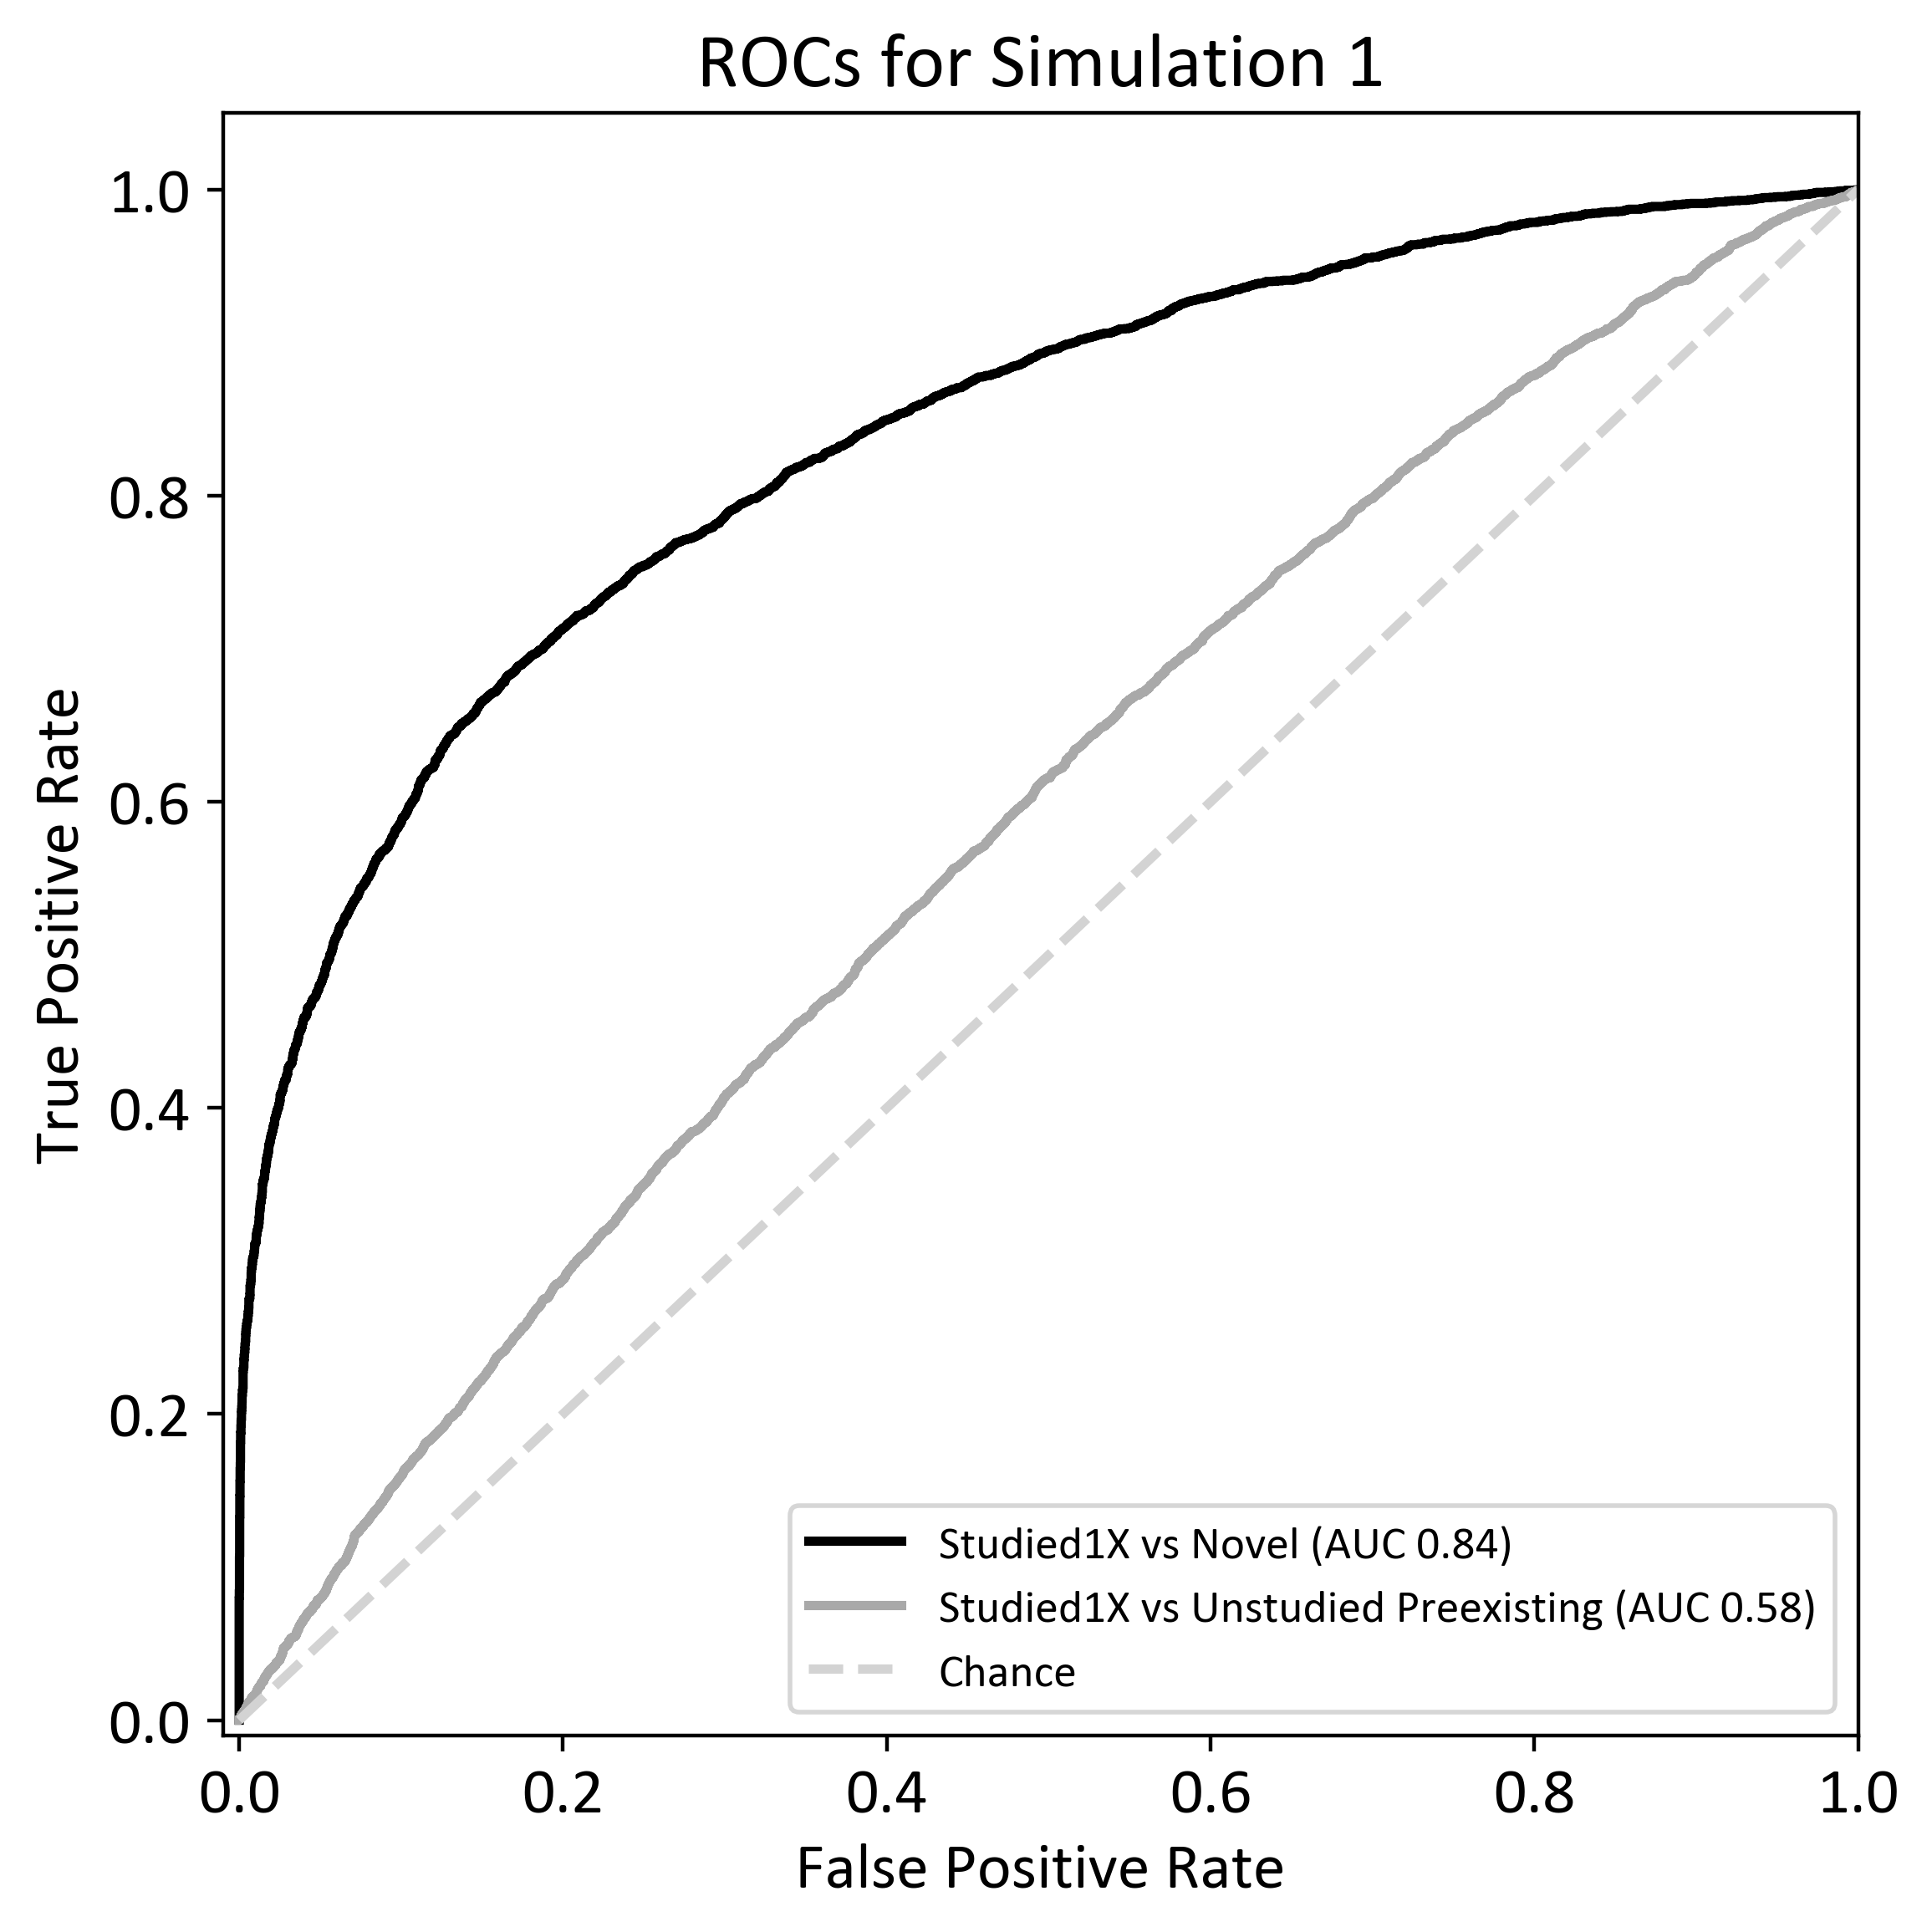

[(0.7218, 0.7914, 1.3639866600040451, 0.83687154),
 (0.5564, 0.5590666666666666, 0.28829008812756024, 0.5826903866666666)]

In [47]:
summarize_preknowledge_data(
    [studied_intensities_1x, studied_intensities_1x], 
    [novel_intensities_1x, unstudied_intensities_1x], 
    colors=['black', 'darkgrey'], linestyles=['-','-'], labels=['Studied1X vs Novel', 'Studied1X vs Unstudied Preexisting'],
    title='ROCs for Simulation 1', filename='ROC_1x.png', print_data=True)

Calculating for Studied2X vs Unstudied Preexisting
threshold: 6.697730180330672e-07
Sensitivity (TPR): 0.6372
Specificity (1-FPR): 0.5587333333333333
d-prime 0.45448066732865594
Calculating for Studied4X vs Unstudied Preexisting
threshold: 8.761230653076632e-07
Sensitivity (TPR): 0.6754
Specificity (1-FPR): 0.6721333333333334
d-prime 0.8614133641668719
Calculating for Studied4X vs Studied2X
threshold: 1.0739750849377123e-06
Sensitivity (TPR): 0.561
Specificity (1-FPR): 0.6122000000000001
d-prime 0.4133470877640774


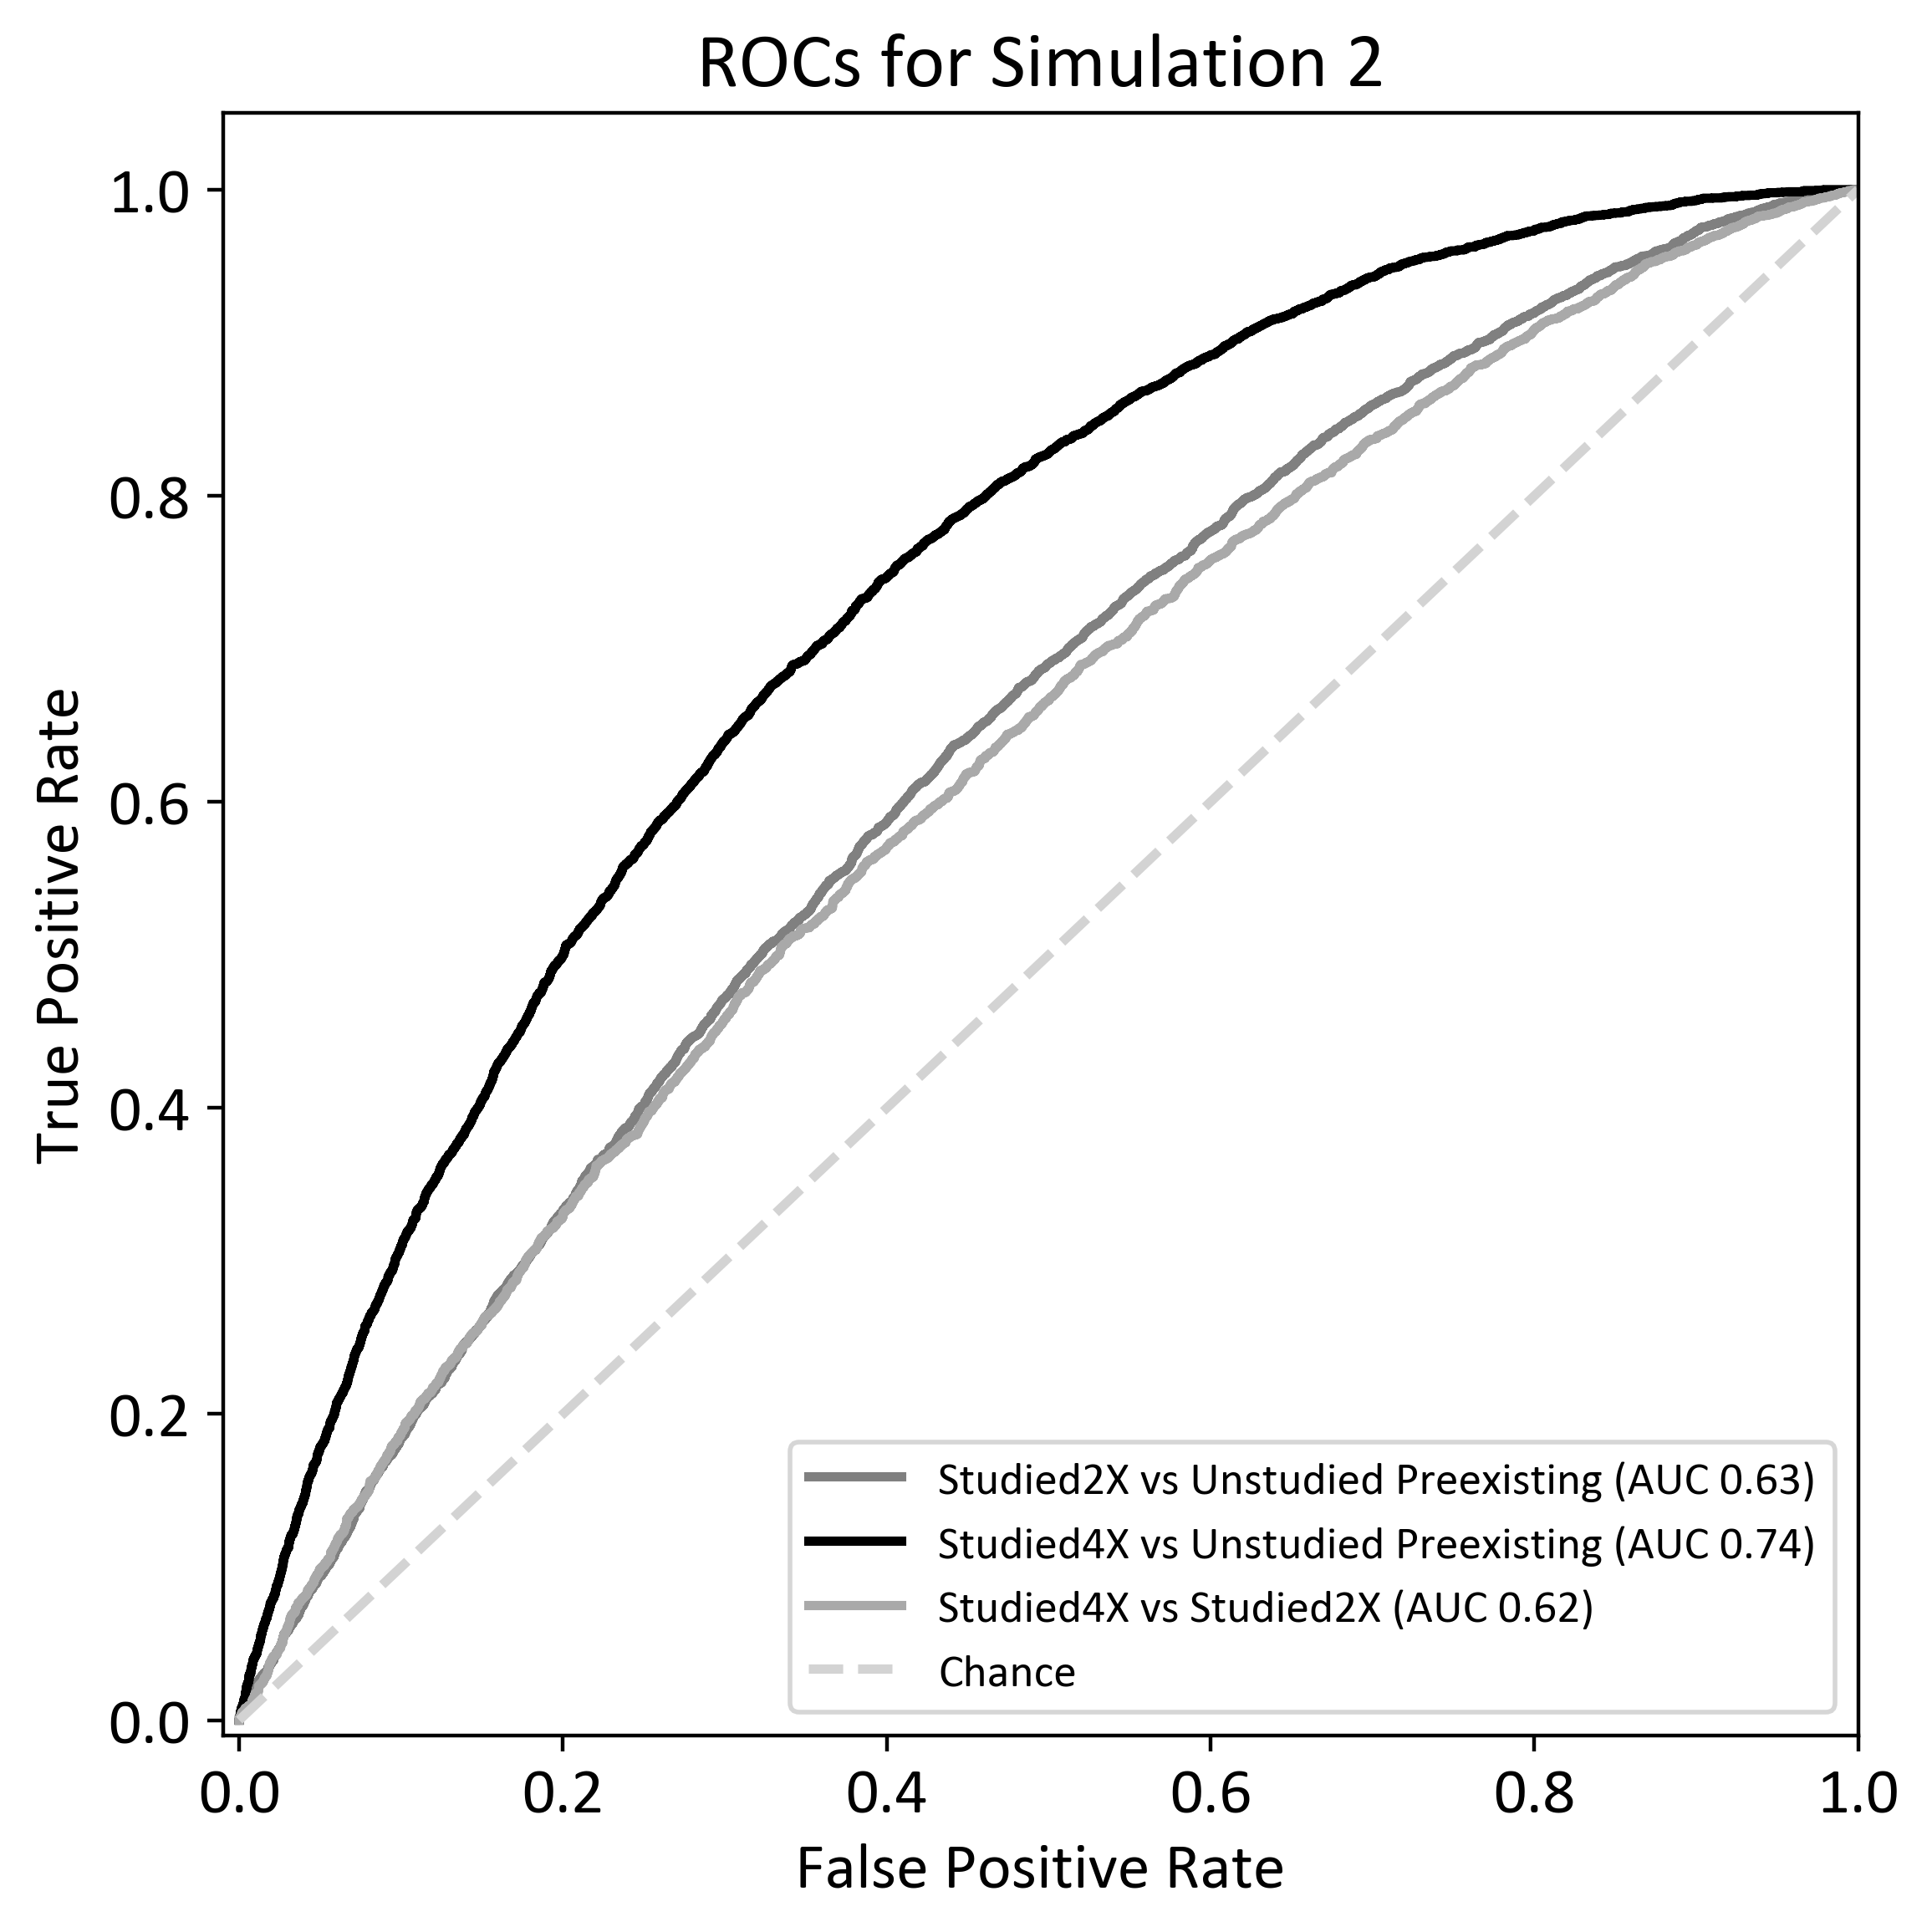

[(0.6372, 0.5587333333333333, 0.45448066732865594, 0.6308455733333334),
 (0.6754, 0.6721333333333334, 0.8614133641668719, 0.73547648),
 (0.561, 0.6122000000000001, 0.4133470877640774, 0.61897144)]

In [48]:
summarize_preknowledge_data(
    [studied_intensities_2x, studied_intensities_4x, studied_intensities_4x], 
    [unstudied_intensities_1x, unstudied_intensities_1x, studied_intensities_2x], 
    colors=['grey', 'black', 'darkgrey'], linestyles=['-','-', '-'], labels=['Studied2X vs Unstudied Preexisting', 'Studied4X vs Unstudied Preexisting', 'Studied4X vs Studied2X'],
    title='ROCs for Simulation 2', filename='ROC_many.png', print_data=True)

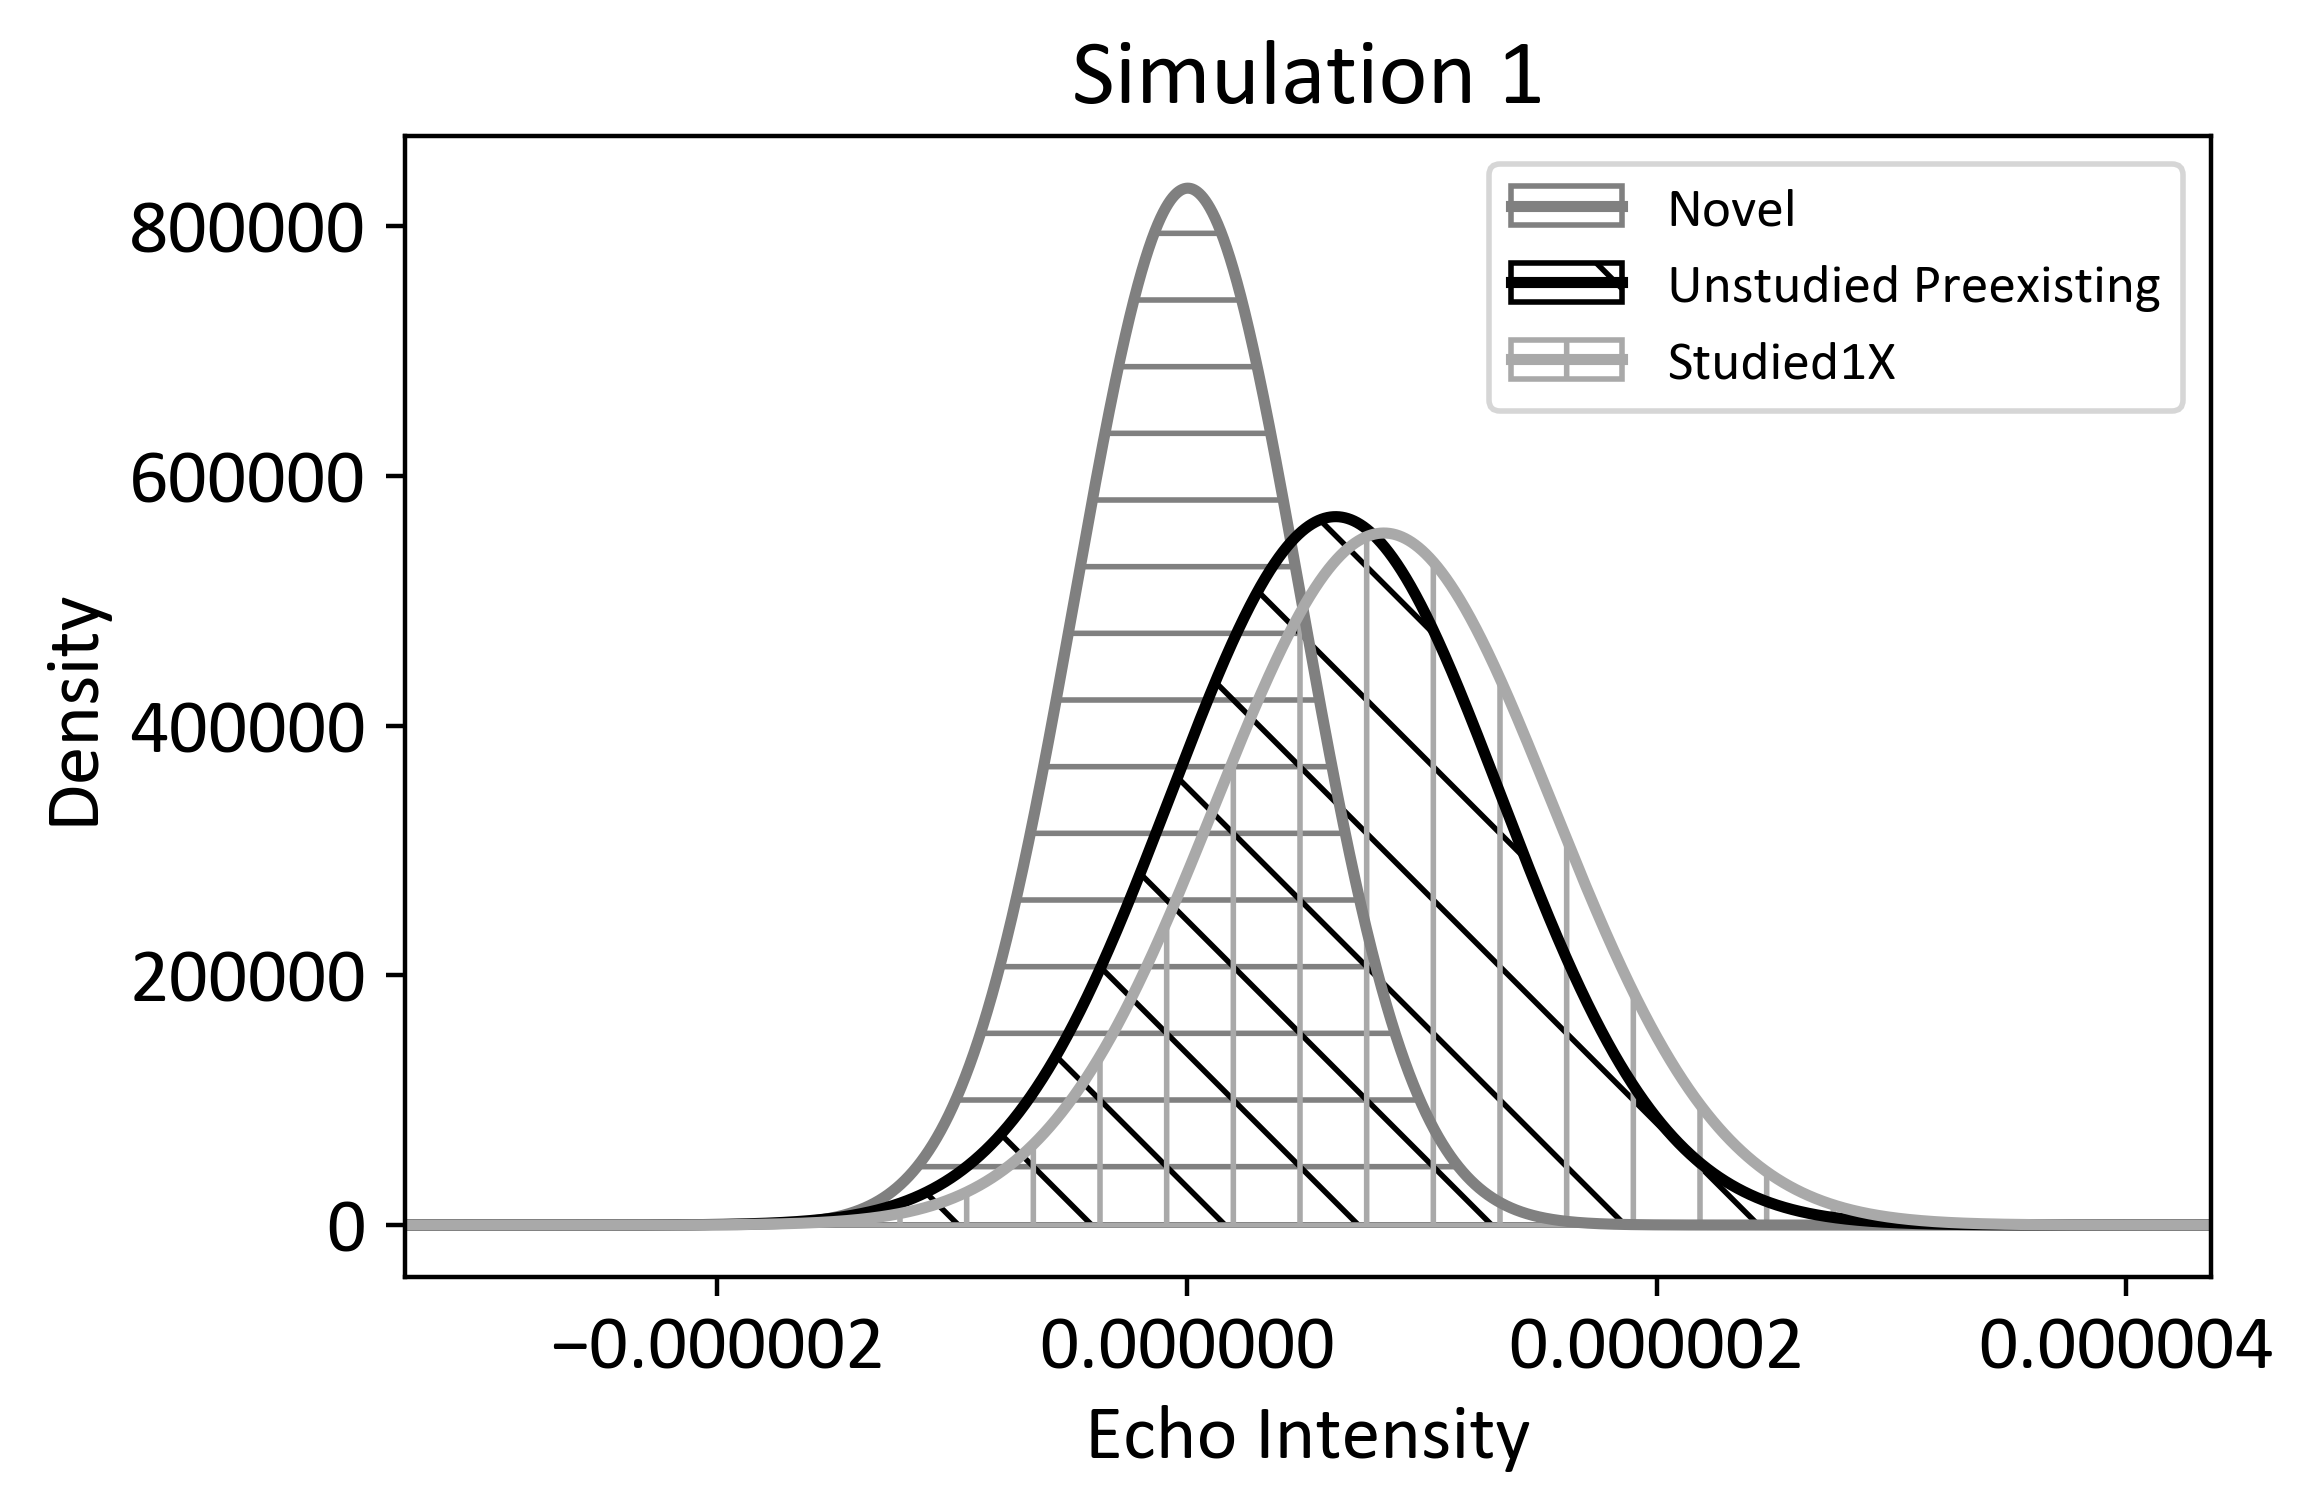

In [49]:
plot_preknowledge_data(
    [novel_intensities_1x, unstudied_intensities_1x, studied_intensities_1x], 
    colors_list=['grey', 'black', 'darkgrey'], 
    hatches_list=['-', '\\', '|'], 
    labels_list=['Novel', 'Unstudied Preexisting', 'Studied1X'], 
    title='Simulation 1', xlabel='Echo Intensity', ylabel='Density', filename='Studied1X.png')

In [67]:
np.hstack((unstudied_intensities_1x, studied_intensities_1x))

array([ 1.18884835e-07,  5.52850825e-07,  7.02194415e-07, ...,
        1.13223090e-06,  2.17608458e-06, -1.27311893e-07])

In [68]:
np.greater(
            np.hstack((unstudied_intensities_1x, studied_intensities_1x)), 
            1e-4
        ), 

(array([False, False, False, ..., False, False, False]),)

In [69]:
len(unstudied_intensities_1x) ,len(studied_intensities_1x)

(10000, 10000)

In [70]:
np.sum(
    np.equal(
        np.greater(
            np.hstack((unstudied_intensities_1x, studied_intensities_1x)), 
            1e-4
        ), 
        np.hstack((np.zeros_like(unstudied_intensities_1x), np.ones_like(studied_intensities_1x)))
    )
) / (len(unstudied_intensities_1x) + len(studied_intensities_1x))

0.5

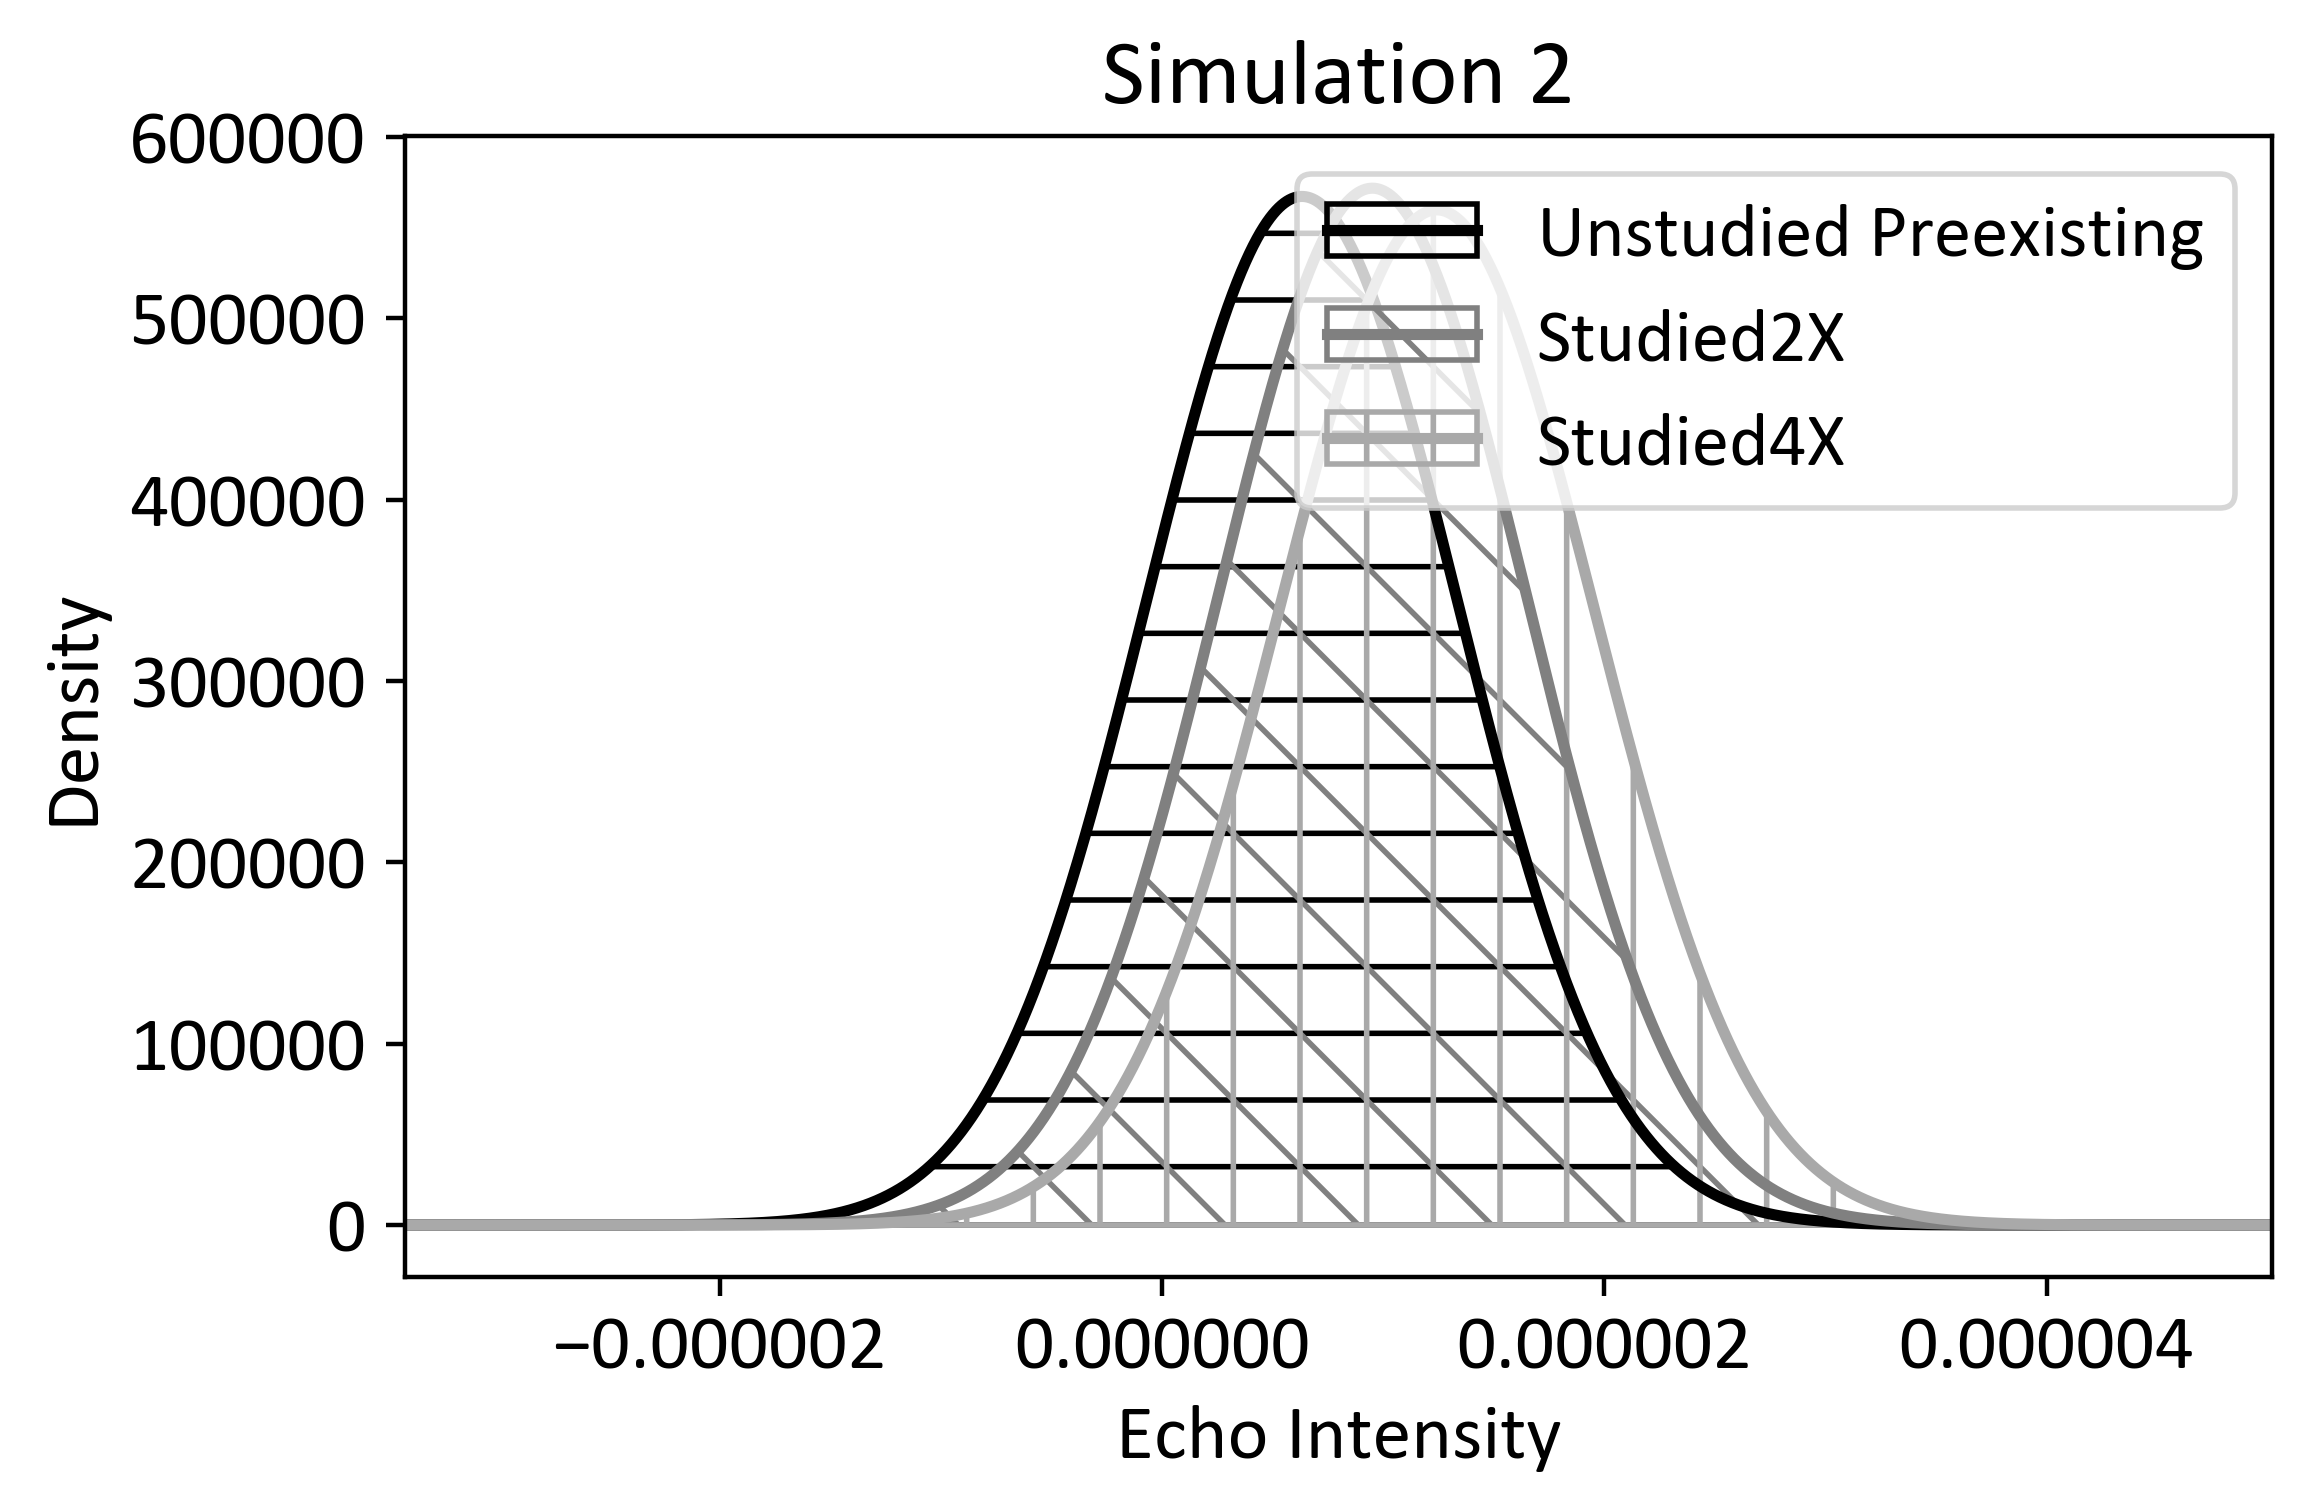

In [27]:
plot_preknowledge_data(
    [unstudied_intensities_1x, studied_intensities_2x, studied_intensities_4x], 
    colors_list=['black', 'gray', 'darkgray'], 
    hatches_list=['-', '\\', '|'], 
    labels_list=['Unstudied Preexisting', 'Studied2X', 'Studied4X'], 
    title='Simulation 2', xlabel='Echo Intensity', ylabel='Density', filename='Studied2X_and_4X.png')